# Projekt zaliczeniowy - Analiza danych z Pythonem

Celem tego projektu jest analiza oraz przeprowadzenie testów statystycznych na podstawie historycznych danych ubezpieczeniowych. Wykorzystując techniki data science, przeanalizuję kluczowe czynniki wpływające na częstość szkód, takie jak dane demograficzne ubezpieczonych, charakterystyka pojazdów oraz wzorce historycznych roszczeń. Ostatecznym celem jest dostarczenie ubezpieczycielom praktycznych informacji umożliwiających optymalizację strategii taryfowych oraz usprawnienie zarządzania ryzykiem.

Źródło danych: R-Package CASDatasets, Version 1.0-6 (2016) by Christophe Dutang [aut, cre], Arthur Charpentier [ctb]

* **IDpol** – identyfikator polisy
* **ClaimNb** – liczba szkód w okresie ekspozycji
* **Exposure** – okres ekspozycji
* **Area** – kod obszaru
* **VehPower** – moc pojazdu, jako kategoria
* **VehAge** – wiek pojazdu (w latach)
* **DrivAge** – wiek kierowcy (w latach; we Francji prawo jazdy można uzyskać od 18 roku życia)
* **BonusMalus** – współczynnik bonus/malus, w przedziale 50–230 (wartości <100 oznaczają bonus, >100 – malus)
* **VehBrand** – marka pojazdu (zakodowana kategoria)
* **VehGas** – rodzaj paliwa (Diesel lub benzyna)
* **Density** – gęstość zaludnienia (liczba mieszkańców na km²) w mieście, w którym mieszka kierowca
* **Region** – region ubezpieczenia we Francji (na podstawie standardowej klasyfikacji francuskiej)

Link do repozytorium GitHub: https://github.com/NGala540/PrzewidywanieCzestosciSzkod

### import bibliotek

In [87]:
import pandas as pd
import numpy as np
from tabulate import tabulate

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import math as m
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter, PercentFormatter
from pandas.api.types import is_numeric_dtype
from typing import Union, Literal

### Deklaracje funkcji

In [88]:
def znjadz_odstajace(df: pd.DataFrame, threshold=1.5, method="IQR"):
    '''
    Wykrywa wartości odstające w danych liczbowych DataFrame przy użyciu metody rozstępu międzykwartylowego (IQR) lub z-score.
    Wyświetla podsumowanie wykrytych wartości odstających dla każdej kolumny numerycznej.

    df (pd.DataFrame): DataFrame, w którym wykrywane są wartości odstające
    threshold (float, domyślnie=1.5): Mnożnik dla IQR lub liczba odchyleń standardowych dla z-score.
    method (str, domyślnie="IQR"): Metoda wykrywania wartości odstających ("IQR" lub "z_score").
    '''

    # wybierz tylko kolumny numeryczne
    numeric_df = df.select_dtypes(include=[np.number])

    # deklaracja wierszy do podsumowania
    results = {
        "Granice (Min / Max)": [],
        "Liczba odstających": [],
        "Udział odstających [%]": [],
        "Powyżej górnej granicy": [],
        "Poniżej dolnej granicy": []
    }

    # obliczanie wartości odstających w zależności od wybranej metody
    if method == "IQR":
        q1s = numeric_df.quantile(0.25)
        q3s = numeric_df.quantile(0.75)
        IQRs = q3s - q1s

        min_bounds = q1s - threshold * IQRs
        max_bounds = q3s + threshold * IQRs
    elif method == "z_score":
        means = numeric_df.mean()
        stds = numeric_df.std()
        
        min_bounds = means - threshold * stds
        max_bounds = means + threshold * stds
    else:
        raise ValueError("valid method values are: [IQR, z_score]")

    # wypełnianie ramki podsumowania
    column_names = []
    for col in numeric_df.columns:
        min_bond = min_bounds[col]
        max_bond = max_bounds[col]

        outliers = numeric_df[col]
        outliers_mask = (outliers < min_bond) | (outliers > max_bond)
        outliers_count = outliers_mask.sum()

        column_names.append(col)
        results["Granice (Min / Max)"].append(f"{min_bond:.3f} / {max_bond:.3f}")
        results["Liczba odstających"].append(outliers_count)
        results["Udział odstających [%]"].append(round(100*outliers_count/df.shape[0],2))
        results["Powyżej górnej granicy"].append((outliers > max_bond).sum())
        results["Poniżej dolnej granicy"].append((outliers < min_bond).sum())

    # wyświetlanie podsumowania wartości odstających, jeśli występują
    if results["Liczba odstających"]:
        df_results = pd.DataFrame(results, index=column_names).T
        print(f"Wartości odstające wykryte metodą {method} z parametrem {threshold}:\n")
        print(tabulate(df_results, headers="keys"))
        print("\n")
    else:
        print("Nie znaleziono wartości odstających.")

In [89]:
def wykres_analizy_modelu(data: pd.DataFrame,
                        x: str, 
                        y: str, 
                        w: str = None, 
                        y_pred: np.array = None, 
                        y_pred_prev: np.array = None, 
                        x_min: float = 0, 
                        x_max: float = None, 
                        n_bins: int = 10, 
                        bin_size: float = None, 
                        show: bool = True, 
                        x_max_quantile: float = None, 
                        max_categories: int = None, 
                        categories_threshold: Union[int, float] = None, 
                        categories_list: list[str] = None, 
                        format_x: bool = True, 
                        model_kind: Literal['poisson', 'gamma', 'binomial'] = 'poisson', 
                        dispersion: float = 1.0, 
                        dispersion_prev: float = 1.0, 
                        sort_categories: bool = False,
                        title: str =''):
    """
    Tworzy wykres dwuosiowy porównujący wartości rzeczywiste z wartościami przewidywanymi w różnych segmentach (przedziałach lub kategoriach) cechy „x”.
    Obejmuje średnie ważone i przedziały ufności oparte na określonym rozkładzie modelu.
    """
    
    # --- Przygotowanie danych ---
    x_label = x
    y_label = y

    # Wyodrębnij kolumny jako serie, aby ułatwić manipulację
    x = data[x].squeeze()
    y = data[y].squeeze()  

    # Wagi (ekspozycja)
    if w is not None:
        w_label = w
        w = data[w].squeeze()
    else:
        w = pd.Series(np.ones(len(data)))

    # --- Wykrywanie typu cechy (kategoryczna vs numeryczna) ---
    # Heurystyka: Jeśli x jest numeryczna, ale ma tylko 2 unikalne wartości (0 i 1), traktuj ją jako kategoryczną.
    if is_numeric_dtype(x.dtype):
        x_unique = x.unique()
        if len(x_unique) == 2 and 0 in x_unique and 1 in x_unique:
            x = x.astype('str').astype('category')

    # Sprawdź, czy cecha jest efektywnie kategoryczna
    is_categorical = x.dtype == 'category' or x.dtype == 'object'

    # --- Przetwarzanie danych kategorycznych ---
    if is_categorical:
        cats_means = {} # Słownik do przechowywania wyników dla każdej kategorii
        
        # Określ, które kategorie mają być wykreślone
        if categories_list is None:
            categories_list = list(x.unique()) # Domyślnie: użyj wszystkich kategorii
            
            # Logika filtrowania kategorii na podstawie progów częstości
            if categories_threshold is not None:
                if type(categories_threshold) == int:
                    # Zachowaj kategorie z liczbą >= threshold
                    categories_counts = x.value_counts()
                if type(categories_threshold) == float:
                    # Zachowaj kategorie z udziałem >= threshold
                    categories_counts = x.value_counts(normalize=True)
                
                categories_list = list(categories_counts[categories_counts >= categories_threshold].index)
            
            elif max_categories is not None:
                # Zachowaj N najczęstszych kategorii
                categories_counts = x.value_counts()
                categories_list = list(categories_counts.index)
            
            # Ogranicz liczbę kategorii, jeśli ustawiono max_categories
            if max_categories is not None:
                categories_list = list(categories_list[:max_categories])
        
        # Zachowaj tylko kategorie z co najmniej jedną obserwacją
        categories_counts = x.value_counts()
        categories_list = [cat for cat in categories_list if categories_counts.get(cat, 0) > 0]
        
        # Pętla po wybranych kategoriach w celu obliczenia metryk
        for c in categories_list:
            mask_cat = x == c # Maska logiczna dla bieżącej kategorii
            cat_y = y[mask_cat]
            cat_w = w[mask_cat]
            
            # Oblicz średnią ważoną rzeczywistych wartości (target)
            # Wzór: suma(y * w) / suma(w)
            if sum(cat_w) > 0:
                y_result = np.average(cat_y, weights=cat_w)
                cat_count = sum(cat_w) # Całkowita ekspozycja/waga dla tej kategorii
                cats_means[c] = {
                    'count': cat_count,
                    'y': y_result}
                    
            # Oblicz metryki dla bieżącej predykcji modelu
            if y_pred is not None:
                cat_y_pred = y_pred[mask_cat]
                y_pred_result = np.average(cat_y_pred, weights=cat_w)
                # Oblicz wariancję dla przedziału ufności (logika zależy od funkcji get_variance)
                # q_var = get_variance(y_pred_result, model_kind, dispersion) 
                # Zakładamy prostą wariancję Poissona: Var = Mean
                q_var = y_pred_result 
                
                cats_means[c].update({'y_pred': y_pred_result, 'var': q_var})
            
            # Oblicz metryki dla poprzedniej predykcji modelu (jeśli podano)
            if y_pred_prev is not None:
                cat_y_pred_prev = y_pred_prev[mask_cat]
                y_pred_prev_result = np.average(cat_y_pred_prev, weights=cat_w)
                # q_var_prev = get_variance(y_pred_prev_result, model_kind, dispersion)                 
                q_var_prev = y_pred_prev_result
                
                cats_means[c].update({'y_pred_prev': y_pred_prev_result, 'var_prev': q_var_prev})
    # --- Przetwarzanie danych numerycznych (binning) ---
    else:  
        # Określ limity osi X
        if x_min is None:
            x_min = x.min()
        if x_max is None:
            # Opcja odcięcia wartości odstających za pomocą kwantyla (np. 0.99)
            if x_max_quantile is not None:
                assert x_max_quantile < 1 and x_max_quantile > 0
                x_max = x.quantile(x_max_quantile)
            else:
                x_max = x.max()
        
        # Określ konfigurację binów
        if bin_size is None:
            # Oblicz rozmiar binu na podstawie liczby binów
            bin_size = (x_max - x_min) / n_bins
        else:
            # Oblicz liczbę binów na podstawie rozmiaru binu
            n_bins = int((x_max - x_min) / bin_size)
        
        # Utwórz biny histogramu
        bin_counts, bin_edges = np.histogram(x, bins=n_bins, range=(x_min, x_max))
        ranges_means = {}
        
        prev_b = bin_edges[0]
        
        # Pętla po binach w celu obliczenia metryk
        for i, b in enumerate(bin_edges):
            if i > 0:
                # Zdefiniuj maskę logiczną dla bieżącego binu
                if i + 1 == len(bin_edges):
                    mask_bin = (x >= prev_b) & (x <= b) # Uwzględnij prawą krawędź dla ostatniego binu
                else:
                    mask_bin = (x >= prev_b) & (x < b)
                    
                bin_y = y[mask_bin]
                bin_w = w[mask_bin]
                
                # Oblicz średnie ważone, jeśli bin nie jest pusty
                if len(bin_w) > 0 and sum(bin_w) > 0:
                    y_result = np.average(bin_y, weights=bin_w)
                    bin_center = np.round(np.mean([prev_b, b]),1) # Współrzędna X do wykresu
                    ranges_means[bin_center] = {'y': y_result, 'count': sum(bin_w)}
                    
                    # Statystyki bieżącego modelu
                    if y_pred is not None:
                        bin_y_pred = y_pred[mask_bin]
                        y_pred_result = np.average(bin_y_pred, weights=bin_w)
                        # q_var = get_variance(y_pred_result, model_kind, dispersion) 
                        q_var = y_pred_result # Zastępnik dla brakującej funkcji
                        ranges_means[bin_center].update({'y_pred': y_pred_result, 'var': q_var})
                    
                    # Statystyki poprzedniego modelu
                    if y_pred_prev is not None:
                        bin_y_pred_prev = y_pred_prev[mask_bin]
                        y_pred_prev_result = np.average(bin_y_pred_prev, weights=bin_w)
                        ranges_means[bin_center].update({'y_pred_prev': y_pred_prev_result})
                        # q_var_prev = get_variance(y_pred_prev_result, model_kind, dispersion)                 
                        q_var_prev = y_pred_prev_result # Zastępnik
                        ranges_means[bin_center].update({'y_pred_prev': y_pred_prev_result, 'var_prev': q_var_prev})                       
            prev_b = b
    # --- Przygotowanie wykresu ---
    # Utwórz formatery dla czytelnych etykiet osi (np. separator tysięcy)
    formatter = FuncFormatter(lambda x, pos: '{:,.1f}'.format(x).replace(',', ' '))
    
    if model_kind in ['poisson', 'binomial']:
        freq_formatter = PercentFormatter(xmax=1.0, decimals=1) # np. 10.5%
    
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    ax_twin = ax.twinx() # Utwórz drugą oś Y dzielącą oś X
    
    # --- Wykres dla danych kategorycznych ---
    if is_categorical:
        cats_means = dict(sorted(cats_means.items(), key=lambda item: item[1]['count'], reverse=True))
        if sort_categories:
            cats_means = dict(sorted(cats_means.items()))
        
        # Wykreśl tylko kategorie z co najmniej jedną obserwacją
        plot_keys = [k for k, v in cats_means.items() if v['count'] > 0]
        
        # Wykreśl ekspozycję/liczbę jako słupki na głównej osi (lewej)
        ax.bar(plot_keys, [cats_means[k]['count'] for k in plot_keys], color='#BF1528')
        
        # Wykreśl rzeczywiste i przewidywane jako linie na drugiej osi (prawej)
        ax_twin.plot(plot_keys, [cats_means[k]['y'] for k in plot_keys], color='orange', marker='s', linestyle='none', label='Wartość rzeczywista')
        
        if y_pred_prev is not None:
            ax_twin.plot(plot_keys, [cats_means[k]['y_pred_prev'] for k in plot_keys], color='#D90166', marker='o', linestyle='none', label='Wartość przewidywana (poprzedni model)')
        
        if y_pred is not None:
            ax_twin.plot(plot_keys, [cats_means[k]['y_pred'] for k in plot_keys], color='black', marker='o', linestyle='none', label='Wartość przewidywana (nowy model)' if y_pred_prev is not None else 'Predicted Value')
        
        # Konfiguracja lokalizacji osi
        ax.set_xlabel(x_label)
        ax.yaxis.set_major_formatter(formatter)
        
        # Zamiana stron osi: skala słupków po prawej, skala linii po lewej
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax_twin.yaxis.tick_left()
        ax_twin.yaxis.set_label_position("left")
        
        ax.grid(True, alpha=0.5)
        ax_twin.grid(False) # Wyłącz siatkę dla drugiej osi, by uniknąć bałaganu
        
        # Rozpocznij oś Y od 0 dla obu osi
        ax.set_ylim(bottom=0)
        ax_twin.set_ylim(bottom=0)
        
        # Oblicz przedziały ufności (95% CI)
        # Wzór: 1.96 * sqrt(Wariancja / Liczba)
        if y_pred_prev is not None:
            CI = [1.96 * (np.sqrt(cats_means[k]['var']) / np.sqrt(cats_means[k]['count'])) for k in plot_keys]
        
        if y_pred_prev is not None:
            CI_prev = [1.96 * (np.sqrt(cats_means[k]['var_prev']) / np.sqrt(cats_means[k]['count'])) for k in plot_keys]
        
        # Wykreśl zacieniowany obszar dla przedziału ufności
        if y_pred is not None:
            ax_twin.fill_between(plot_keys, 
                             [np.maximum(cats_means[k]['y_pred'] - ci, 0) for k, ci in zip(plot_keys, CI)], 
                             [cats_means[k]['y_pred'] + ci for k, ci in zip(plot_keys, CI)], 
                             color='#575756', alpha=.6)
    # --- Wykres dla danych numerycznych (histogram) ---
    else:     
        # Wykreśl tylko biny z co najmniej jedną obserwacją
        plot_keys = [k for k, v in ranges_means.items() if v['count'] > 0]
        
        # Wykreśl histogram ekspozycji na głównej osi
        ax.bar(plot_keys, [ranges_means[k]['count'] for k in plot_keys], color='#BF1528', width=(bin_edges[1]-bin_edges[0])*0.9)
        
        # Wykreśl linie na drugiej osi
        ax_twin.plot(plot_keys, [ranges_means[k]['y'] for k in plot_keys], color='orange', marker='s', label='Wartość rzeczywista')
        
        if y_pred_prev is not None:
            ax_twin.plot(plot_keys, [ranges_means[k]['y_pred_prev'] for k in plot_keys], color='#D90166', marker='o', label='Predicted (Prev Model)')
        
        if y_pred is not None:  
            ax_twin.plot(plot_keys, [ranges_means[k]['y_pred'] for k in plot_keys], color='black', marker='o', label='Predicted (New Model)' if y_pred_prev is not None else 'Predicted Value')
        
        ax.set_xlabel(x_label)
        
        if format_x == True:
            ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        
        # Zamiana stron osi (jak dla kategorycznych)
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax_twin.yaxis.tick_left()
        ax_twin.yaxis.set_label_position("left")
        
        ax.grid(True, alpha=0.5)
        ax_twin.grid(False) # Wyłącz siatkę dla drugiej osi, by uniknąć bałaganu
        
        # Rozpocznij oś Y od 0 dla obu osi
        ax.set_ylim(bottom=0)
        ax_twin.set_ylim(bottom=0)
        
        # Oblicz i wykreśl przedziały ufności dla danych binowanych
        if y_pred is not None:
            CI = [1.96 * (np.sqrt(ranges_means[k]['var']) / np.sqrt(ranges_means[k]['count'])) for k in plot_keys]
        
        if y_pred is not None:
            ax_twin.fill_between(plot_keys, 
                             [np.maximum(ranges_means[k]['y_pred'] - ci, 0) for k, ci in zip(plot_keys, CI)], 
                             [ranges_means[k]['y_pred'] + ci for k, ci in zip(plot_keys, CI)], 
                             color='#575756', alpha=.6)
    # --- Finalne etykiety i legenda ---
    # Ustaw etykiety osi na podstawie typu modelu statystycznego
    if model_kind == 'poisson':
        ax.set_ylabel('Exposure')
        ax_twin.set_ylabel('Claim Frequency')
        ax_twin.yaxis.set_major_formatter(freq_formatter)
    elif model_kind == 'gamma':
        ax.set_ylabel('Number of Events')
        ax_twin.set_ylabel('Average Severity')
        ax_twin.yaxis.set_major_formatter(formatter)
    elif model_kind == 'binomial':
        ax.set_ylabel('Number of Offers')
        ax_twin.set_ylabel('Conversion Rate')
        ax_twin.yaxis.set_major_formatter(freq_formatter)        
    
    ax.set_title(title)
    plt.legend() # Pokazuje legendę dla linii
    
    if show:
        plt.show()

In [90]:
def wyswietl_macierz_korelacji(dane: pd.DataFrame, rozmiar=(12,8), tytul='Macierz korelacji'):
    '''
    Wizualizuje macierz korelacji zmiennych numerycznych w podanym DataFrame.

    dane (pd.DataFrame): Wejściowy DataFrame zawierający dane.
    rozmiar (tuple, domyślnie=(12,8)): Rozmiar wykresu dla heatmapy.
    '''
    macierz_korelacji = dane.select_dtypes(include=[np.number]).corr()
    f, ax = plt.subplots(figsize=rozmiar)
    mapa_kolorow = sns.diverging_palette(230, 20, as_cmap=True)
    plt.title(tytul)
    
    sns.heatmap(macierz_korelacji, cmap=mapa_kolorow, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

## Czyszczenie i przekształcanie danych

In [91]:
df_freq = pd.read_csv("./freMTPL2freq.csv")
df_freq["VehPower"] = df_freq["VehPower"].astype("category")

# Przegląd danych
df_freq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


In [92]:
# Szczegóły danych
df_freq.describe()

,IDpol,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,100.000000,100.000000,230.000000,27000.000000


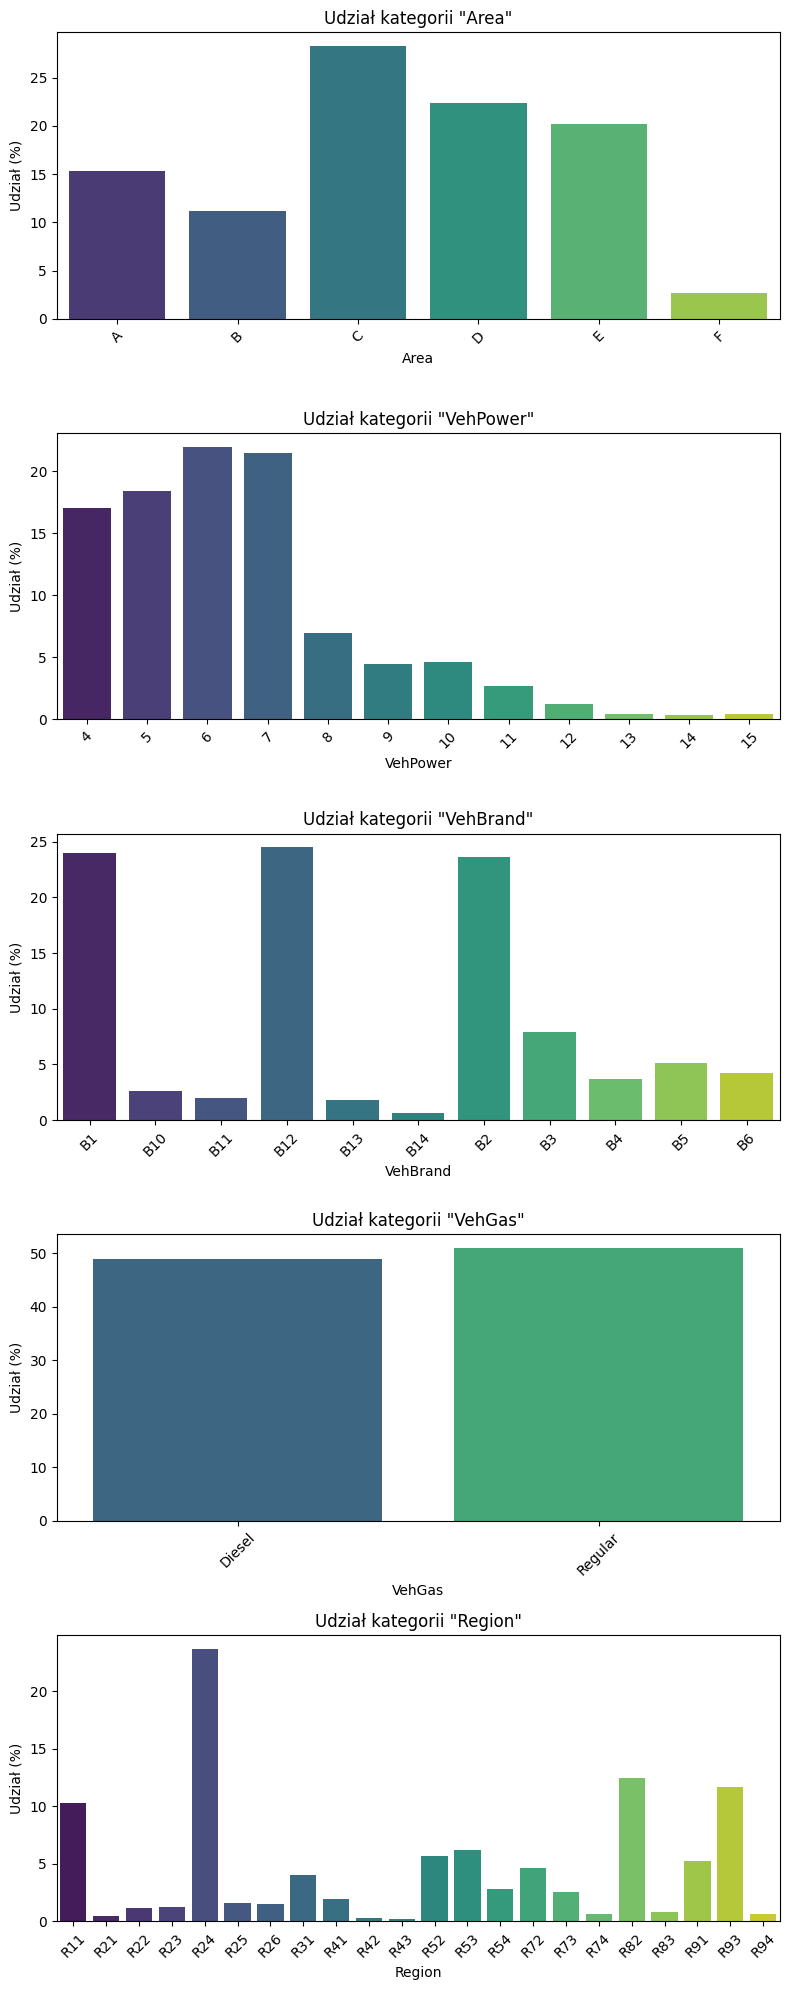

In [93]:
# wizualizacja udziału kategorii we wszystkich cechach kategorycznych
cat_cols = df_freq.select_dtypes(include=["object", "category"]).columns
num_plots = len(cat_cols)
fig, axes = plt.subplots(num_plots, 1, figsize=(8, 4 * num_plots))
if num_plots == 1:
    axes = [axes]
for i, col in enumerate(cat_cols):
    aggregated = (
        df_freq.groupby(col, observed=True)["IDpol"]
        .agg(count="count")
        .reset_index()
        .assign(share=lambda x: 100 * x["count"] / len(df_freq))
    )
    sns.barplot(data=aggregated, x=col, y="share", ax=axes[i], hue=col, legend=False, palette="viridis")
    axes[i].set_title(f'Udział kategorii "{col}"')
    axes[i].set_ylabel('Udział (%)')
    axes[i].set_xlabel(col)
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()
plt.show()

Zbiór danych zawiera 12 cech, z których:
- jedna jest kluczem wiersza, nie ma wartości predykcyjnej i zostanie usunięta
- 6 jest numerycznych
- 5 jest kategorycznych

Wszystkie wartości numeryczne wydają się być mocno prawostronnie skośne, co wpłynie na analizę wartości odstających. Zarówno minimalne, jak i maksymalne wartości wydają się rozsądne i logiczne, z wyjątkiem wieku pojazdu i kierowcy, gdzie wartości równe 100 wydają się wysokie. Zostanie to zbadane bardziej szczegółowo w dalszej części. Wartości kategoryczne są w większości nierównomiernie rozłożone pomiędzy kategoriami.

In [94]:
# usuwanie IDpol
df_freq.drop('IDpol', axis=1, inplace=True)

# przegląd wartości brakujących
df_freq.isnull().sum()

ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

In [95]:
# znajdowanie wartości odstających
znjadz_odstajace(df_freq)
znjadz_odstajace(df_freq, threshold=2, method="z_score")

Wartości odstające wykryte metodą IQR z parametrem 1.5:

                        ClaimNb        Exposure        VehAge            DrivAge         BonusMalus       Density
----------------------  -------------  --------------  ----------------  --------------  ---------------  --------------------
Granice (Min / Max)     0.000 / 0.000  -1.035 / 2.205  -11.500 / 24.500  2.500 / 86.500  29.000 / 85.000  -2257.000 / 4007.000
Liczba odstających      34060          0               3114              1275            62384            77566
Udział odstających [%]  5.02           0.0             0.46              0.19            9.2              11.44
Powyżej górnej granicy  34060          0               3114              1275            62384            77566
Poniżej dolnej granicy  0              0               0                 0               0                0


Wartości odstające wykryte metodą z_score z parametrem 2:

                        ClaimNb         Exposure        VehAge        

W zależności od metody liczba obserwacji sklasyfikowanych jako wartości odstające jest różna, ale zazwyczaj jest znaczna. Jeśli jednak wartości mieszczą się w logicznym zakresie, mogą one odzwierciedlać charakterystyczny rozkład cech w zbiorze danych. Dlatego przed podjęciem działań w celu obsługi wartości odstających konieczne jest przeprowadzenie dalszej analizy.

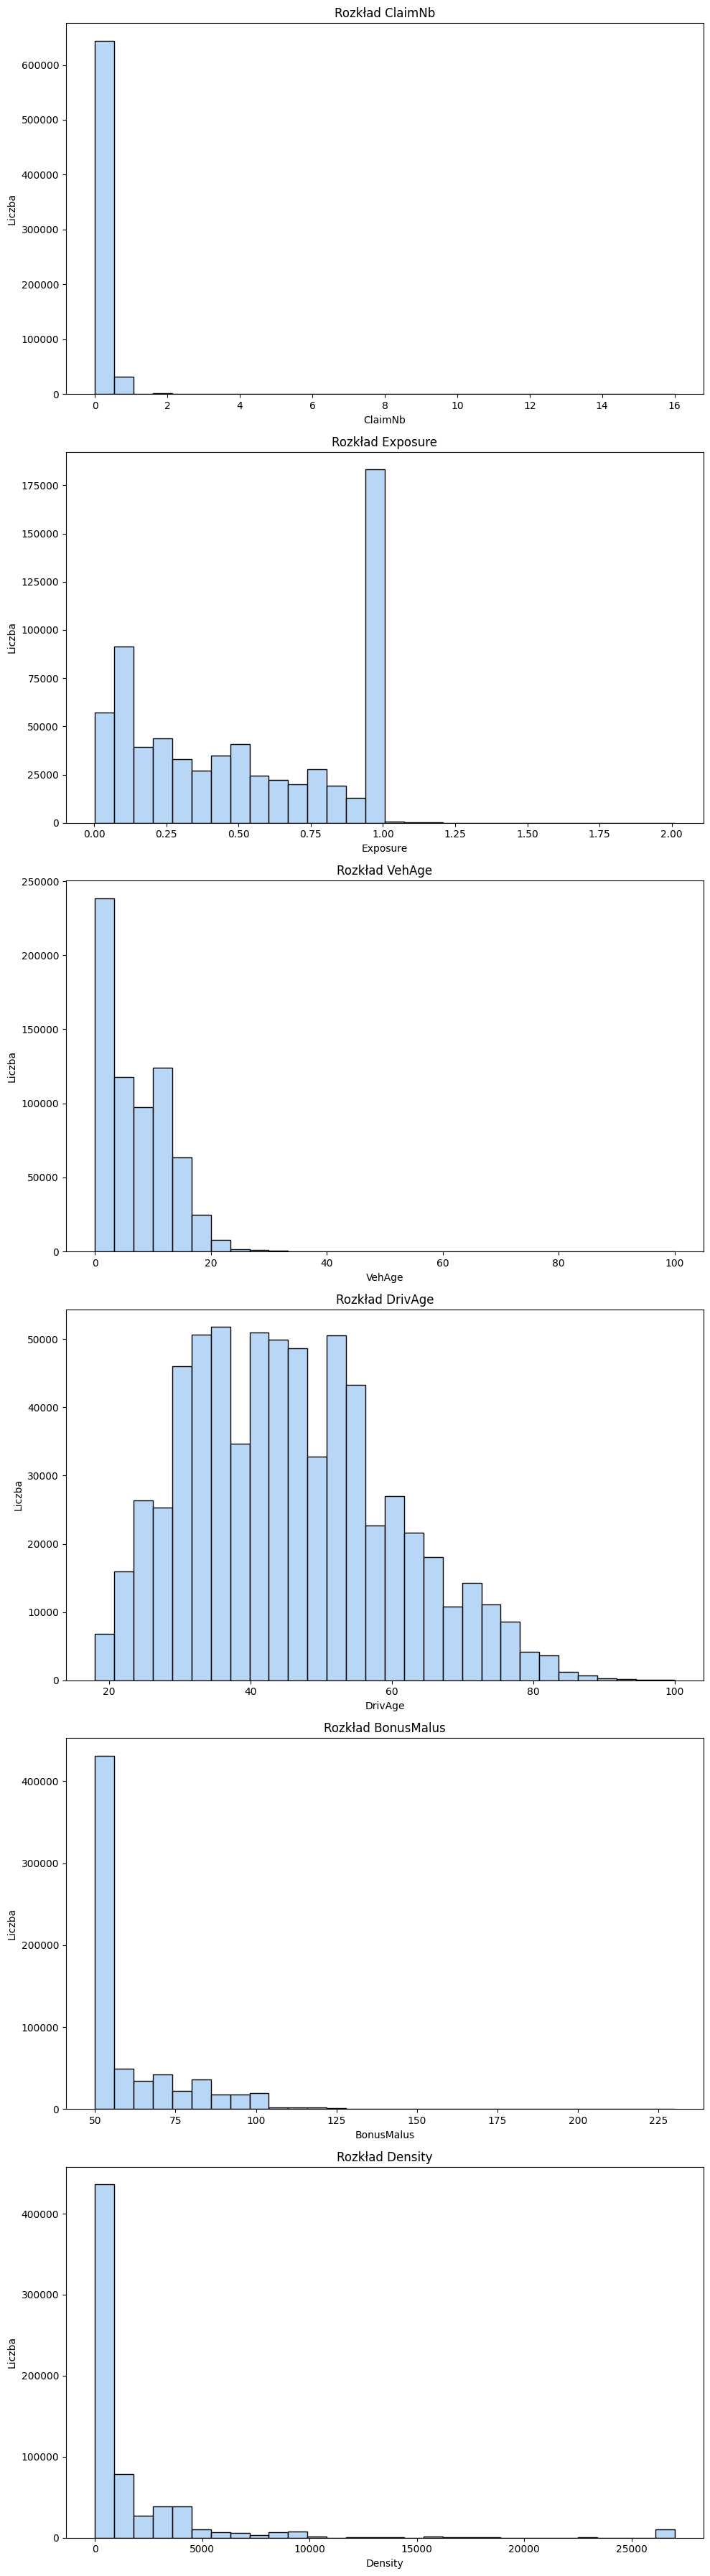

In [96]:
# wykresy rozkładów zmiennych
num_cols = df_freq.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 6 * len(num_cols)))

for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 1, i + 1)
    sns.histplot(data=df_freq, x=col, bins=30)
    plt.title(f"Rozkład {col}")
    plt.xlabel(col)
    plt.ylabel("Liczba")
    
plt.tight_layout()
plt.show()

In [97]:
# Liczba wartości odstających - wiek pojazdu
int(df_freq[df_freq["VehAge"] > 24.5]["VehAge"].count())

3114

<Axes: xlabel='VehAge', ylabel='count'>

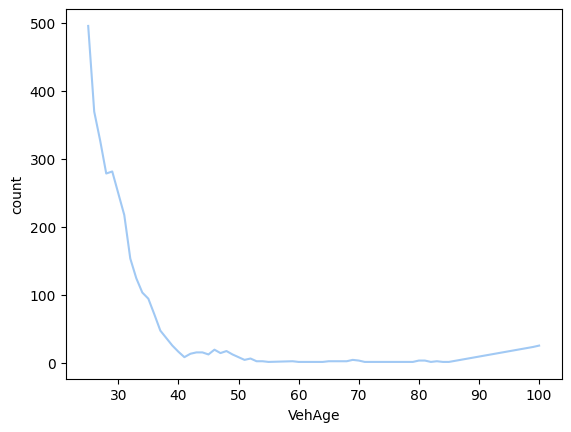

In [98]:
# liczba samochodów w poszczególnych grupach wiekowych powyżej 24.5
temp = df_freq[df_freq["VehAge"] > 24.5].groupby("VehAge").size().reset_index(name="count")
sns.lineplot(data=temp, x="VehAge", y="count")

<Axes: xlabel='DrivAge', ylabel='count'>

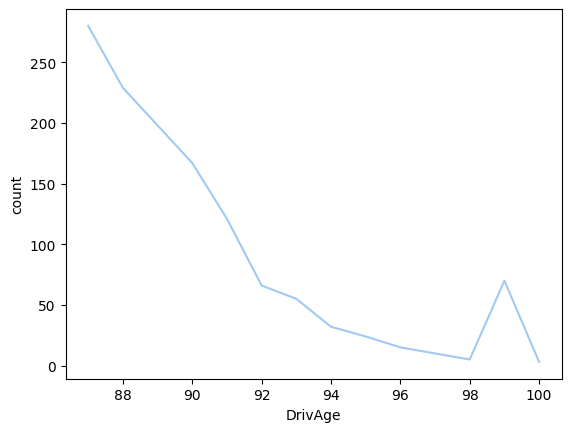

In [99]:
# liczba kierowców w poszczególnych grupach wiekowych powyżej 86.5
temp = df_freq[df_freq["DrivAge"] > 86.5].groupby("DrivAge").size().reset_index(name="count")
sns.lineplot(data=temp, x="DrivAge", y="count")

Istnieje kilka wartości, które można zaklasyfikować jako wartości odstające zarówno w przypadku wieku kierowcy, jak i wieku pojazdu, w oparciu o metody ilościowe i ekspertyzę. Dlatego potraktuję je jako wartości brakujące i uzupełnię te wartości przy użyciu odpowiedniej metody imputacji.

In [100]:
# sprawdzenie obszarów i regionów o najwyższej gęstości 
area_var = ["Area", "Region"]
for col in area_var:
    print(df_freq[df_freq["Density"] >= 27000][col].unique())

['F']
['R11']


In [101]:
# sprawdzenie różnorodności gęstości w regionie i obszarze o największej gęstości
df_freq[(df_freq["Area"] == "F") & (df_freq["Region"] == "R11")]\
    .groupby("Density")["Density"]\
    .count()\
    .sort_values(ascending=False)

Density
27000    10515
17140      910
10156      816
16533      613
15703      557
15725      526
22669      463
10477      344
12374      296
14368      285
12750      225
10155      202
18229      200
16284      194
22821      182
16291      175
10068      171
10961      165
13520      158
12650      154
15386      145
10008      144
13719      119
14200      109
21410       76
12437       70
16052       68
23396       66
20000        6
Name: Density, dtype: int64

Gęstość wynosząca 27000 osób na km kwadratowy wydaje się nieco dziwna, ale nie ma podstaw, aby zajmować się tą wartością, ponieważ występuje ona tylko w regionie 11, obszarze F, a ponadto jest to najczęściej występująca wartość gęstości w tym miejscu.

In [102]:
# eksploracja rozkładu liczby roszczeń
df_freq[df_freq["ClaimNb"] > 0].groupby("ClaimNb").agg({"ClaimNb":"count", "Exposure":"mean"})

,ClaimNb,Exposure
ClaimNb,,
1,32178,0.642388
2,1784,0.646535
3,82,0.643415
4,7,0.438571
5,2,0.540000
6,1,0.330000
8,1,0.410000
9,1,0.080000
11,3,0.383333


In [103]:
df_freq[df_freq["ClaimNb"].isin([9, 11, 16])]

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
6539,11,1.00,A,5,6,65,50,B2,Diesel,13,R24
321248,16,0.33,D,4,12,52,50,B1,Regular,824,R91
321512,9,0.08,D,4,12,52,50,B1,Regular,824,R91
487268,11,0.08,D,4,13,53,50,B1,Regular,824,R91
488270,11,0.07,D,4,13,53,50,B1,Regular,824,R91


Najwyższe wartości liczby roszczeń wyglądają bardzo podejrzanie, zwłaszcza biorąc pod uwagę okres ekspozycji. Na przykład bardzo mało prawdopodobne jest, aby w ciągu miesiąca zgłoszono 9 roszczeń.

Strategia usuwania wartości odstających:
- w przypadku wieku kierowcy i wieku pojazdu usunę wartości powyżej 25 i 87 i zastąpię je z wykorzystaniem algorytmu KNN.
- w przypadku liczby roszczeń nie mogę zastosować tej samej strategii, ponieważ obserwacji dotyczących roszczeń jest bardzo niewiele. Dlatego też ustalę limit roszczeń na 5 i zmienię wszystkie wartości powyżej 5 na 5.

In [104]:
df_freq["DrivAge"] = df_freq["DrivAge"].where(~(df_freq["DrivAge"] > 87), np.nan)
df_freq["VehAge"] = df_freq["VehAge"].where(~(df_freq["VehAge"] > 25), np.nan)

In [105]:
# kodowanie i skalowanie zmiennych do imputacji
to_encode = df_freq[cat_cols]

ohe = OneHotEncoder(sparse_output=False, drop="first")

encoded_array = ohe.fit_transform(to_encode)
encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(to_encode.columns))
df_final = pd.concat([df_freq[num_cols], encoded_df], axis=1)

scaler = StandardScaler()
df_final[num_cols] = scaler.fit_transform(df_final[num_cols])

df_final

,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density,Area_B,Area_C,Area_D,Area_E,...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,3.942880,-1.176459,-1.286080,0.681460,-0.624271,-0.145358,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.942880,0.661972,-1.286080,0.681460,-0.624271,-0.145358,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.942880,0.607093,-0.915705,0.467782,-0.624271,-0.439146,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.942880,-1.203898,-1.286080,0.040425,-0.624271,-0.433589,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.942880,0.854047,-1.286080,0.040425,-0.624271,-0.433589,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,-0.221753,-1.443334,-1.286080,0.610234,-0.624271,0.385126,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
678009,-0.221753,-1.443334,-1.286080,-0.315705,2.253584,2.035439,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
678010,-0.221753,-1.443334,-0.915705,-0.030801,-0.624271,-0.118582,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
678011,-0.221753,-1.443334,-1.286080,1.037590,-0.624271,-0.428789,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# trenowanie imputera i zapisywanie wyników

imputer_age = KNNImputer()
imputed_array = imputer_age.fit_transform(df_final)
with open('imputed_array_age.npy', "wb") as f:
    np.save(f, imputed_array)

In [108]:
# ładowanie wyników modelu imputacji i odwracanie transformacji: kodowanie i skalowanie
with open("imputed_array_age.npy", "rb") as f:
    imputed_array = np.load('imputed_array_age.npy')

df_full = pd.DataFrame(imputed_array, columns=df_final.columns)
decoded_array = ohe.inverse_transform(df_full[encoded_df.columns])
decoded_df = pd.DataFrame(decoded_array, columns=cat_cols)
df_full[num_cols] = scaler.inverse_transform(df_full[num_cols])
df_full = pd.concat([df_full[num_cols], decoded_df], axis=1)

df_full

,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density,Area,VehPower,VehBrand,VehGas,Region
0,1.0,0.10000,0.0,55.0,50.0,1217.0,D,5,B12,Regular,R82
1,1.0,0.77000,0.0,55.0,50.0,1217.0,D,5,B12,Regular,R82
2,1.0,0.75000,2.0,52.0,50.0,54.0,B,6,B12,Diesel,R22
3,1.0,0.09000,0.0,46.0,50.0,76.0,B,7,B12,Diesel,R72
4,1.0,0.84000,0.0,46.0,50.0,76.0,B,7,B12,Diesel,R72
...,...,...,...,...,...,...,...,...,...,...,...
678008,0.0,0.00274,0.0,54.0,50.0,3317.0,E,4,B12,Regular,R93
678009,0.0,0.00274,0.0,41.0,95.0,9850.0,E,4,B12,Regular,R11
678010,0.0,0.00274,2.0,45.0,50.0,1323.0,D,6,B12,Diesel,R82
678011,0.0,0.00274,0.0,60.0,50.0,95.0,B,4,B12,Regular,R26


In [ ]:
# dodanie limitu liczby roszczeń
df_full["ClaimNb"] = df_full["ClaimNb"].where(~(df_full["ClaimNb"] > 5), 5)

# tworzenie cechy częstości roszczeń
df_full["ClaimFrequency"] = df_full["ClaimNb"]/df_full["Exposure"]

In [111]:
# eksploracja danych po czyszczeniu
df_full.describe()

,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density,ClaimFrequency
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.053192,0.528750,6.956447,45.443271,59.761502,1792.422405,0.263580
std,0.238202,0.364442,5.398474,14.038012,15.636658,3958.646564,4.586564
min,0.000000,0.002732,0.000000,18.000000,50.000000,1.000000,0.000000
25%,0.000000,0.180000,2.000000,34.000000,50.000000,92.000000,0.000000
50%,0.000000,0.490000,6.000000,44.000000,50.000000,393.000000,0.000000
75%,0.000000,0.990000,11.000000,55.000000,64.000000,1658.000000,0.000000
max,5.000000,2.010000,25.000000,87.000000,230.000000,27000.000000,732.000000


Po wyczyszczeniu danych i dodaniu cechy częstości roszczeń, zbiór danych jest znacznie bliższy temu, czego oczekujemy przed analizą eksploracyjną. Jednak maksymalna wartość częstości roszczeń wynosząca 732 wydaje się niepoprawna i wymaga dalszego zbadania dla lepszego zrozumienia.

In [112]:
# sprawdzanie szczegółów ekspozycji dla częstości roszczeń wyższej niż dostępna liczba roszczeń
df_full[df_full["ClaimFrequency"] > 5]["Exposure"].describe()

count    5485.000000
mean        0.102694
std         0.070954
min         0.002732
25%         0.050000
50%         0.090000
75%         0.140000
max         0.570000
Name: Exposure, dtype: float64

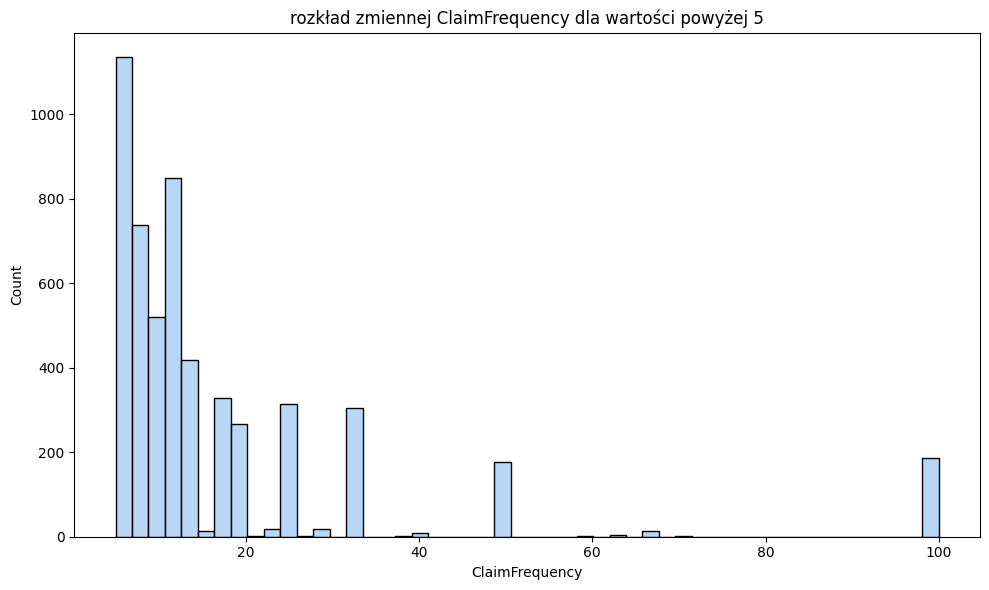

In [113]:
plt.figure(figsize=(10, 6))

sns.histplot(data=df_full[df_full["ClaimFrequency"] > 5], x="ClaimFrequency", bins=50, binrange=(5, 100))
plt.title(f"rozkład zmiennej ClaimFrequency dla wartości powyżej 5")

plt.tight_layout()
plt.show()

Częstości roszczeń w setkach są podejrzane i bardzo mało prawdopodobne. Powodem ich wystąpienia jest roszczenie w bardzo krótkim okresie ekspozycji. Aby te wartości były bardziej realistyczne, zmienię mianownik częstości roszczeń na 1 (mediana) dla przypadków, gdy okres ekspozycji jest poniżej jednej czwartej (0.25).

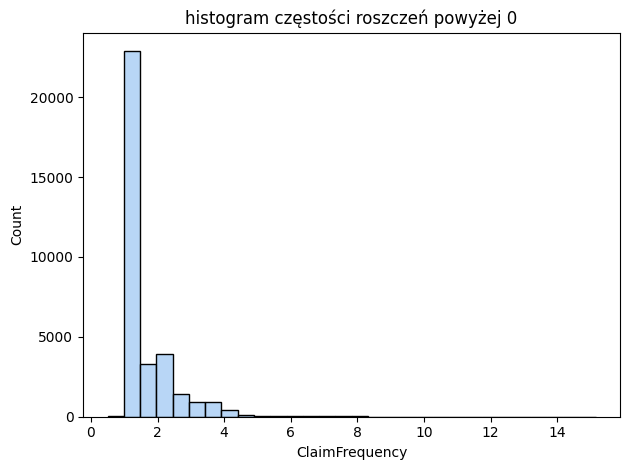

In [114]:
# ponowne obliczenie częstości roszczeń
df_full["ClaimFrequency"] = df_full["ClaimNb"]/df_full["Exposure"].apply(lambda x: x if x >= 0.25 else 1)

# histogram częstości roszczeń powyżej 0
sns.histplot(data=df_full[df_full["ClaimFrequency"] > 0], x="ClaimFrequency", bins=30)
plt.title(f"histogram częstości roszczeń powyżej 0")
plt.tight_layout()
plt.show()

In [115]:
# eksploracja najwyższych wartości częstości roszczeń
df_full[df_full["ClaimFrequency"] > 14]

,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density,Area,VehPower,VehBrand,VehGas,Region,ClaimFrequency
304484,5.0,0.33,12.0,52.0,50.0,824.0,D,4,B1,Regular,R91,15.151515
321248,5.0,0.33,12.0,52.0,50.0,824.0,D,4,B1,Regular,R91,15.151515
364437,4.0,0.27,9.0,23.0,90.0,6924.0,E,5,B3,Diesel,R11,14.814815


Podsumowując proces ładowania i czyszczenia danych, dane zostały załadowane, a typy danych dopasowane. Sprawdziłem zarówno brakujące wartości, jak i wartości odstające. Na końcu dodałem ClaimFrequency jako naszą zmienną zależną. Teraz jestem gotowy do przeprowadzenia analizy eksploracyjnej.

In [117]:
df_full.to_csv("./cleaned_data.csv", index=False)

## Eksploracyjna Analiza Danych

In [119]:
# ładowanie oczyszczonych danych
df_freq = pd.read_csv("./cleaned_data.csv")
df_freq.head()

,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density,Area,VehPower,VehBrand,VehGas,Region,ClaimFrequency
0,1.0,0.10,0.0,55.0,50.0,1217.0,D,5,B12,Regular,R82,1.000000
1,1.0,0.77,0.0,55.0,50.0,1217.0,D,5,B12,Regular,R82,1.298701
2,1.0,0.75,2.0,52.0,50.0,54.0,B,6,B12,Diesel,R22,1.333333
3,1.0,0.09,0.0,46.0,50.0,76.0,B,7,B12,Diesel,R72,1.000000
4,1.0,0.84,0.0,46.0,50.0,76.0,B,7,B12,Diesel,R72,1.190476


In [120]:
# statystyki opisowe
df_freq.describe()

,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density,VehPower,ClaimFrequency
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.053192,0.528750,6.956447,45.443271,59.761502,1792.422405,6.454631,0.076328
std,0.238202,0.364442,5.398474,14.038012,15.636658,3958.646564,2.050906,0.383065
min,0.000000,0.002732,0.000000,18.000000,50.000000,1.000000,4.000000,0.000000
25%,0.000000,0.180000,2.000000,34.000000,50.000000,92.000000,5.000000,0.000000
50%,0.000000,0.490000,6.000000,44.000000,50.000000,393.000000,6.000000,0.000000
75%,0.000000,0.990000,11.000000,55.000000,64.000000,1658.000000,7.000000,0.000000
max,5.000000,2.010000,25.000000,87.000000,230.000000,27000.000000,15.000000,15.151515


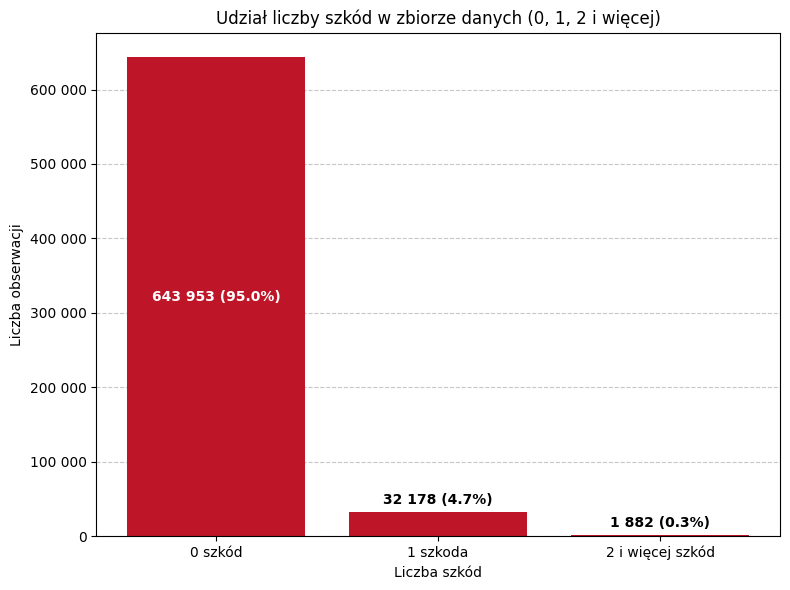

In [121]:
# wizualizacja udziału liczby szkód w zbiorze danych
sns.set_palette("pastel")
claim_agg = df_freq["ClaimNb"].copy()
claim_agg = claim_agg.apply(lambda x: x if x < 2 else 2)
claim_agg = claim_agg.value_counts().sort_index()
labels = ['0 szkód', '1 szkoda', '2 i więcej szkód']
counts = [claim_agg.get(0, 0), claim_agg.get(1, 0), claim_agg.get(2, 0)]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, counts, color='#BF1528', zorder=2)

formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', ' '))
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Liczba szkód')
ax.set_ylabel('Liczba obserwacji')
ax.set_title('Udział liczby szkód w zbiorze danych (0, 1, 2 i więcej)')
ax.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=1)

total = sum(counts)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    count_str = f'{count:,}'.replace(',', ' ')
    label = f'{count_str} ({count/total*100:.1f}%)'
    if height > total * 0.08:
        ax.text(bar.get_x() + bar.get_width()/2, height/2, label, ha='center', va='center', color='white', fontweight='bold')
    else:
        ax.text(bar.get_x() + bar.get_width()/2, height + total*0.01, label, ha='center', va='bottom', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

Tylko około 5% obserwacji zawiera co najmniej jedno roszczenie. Ta nierównowaga klas powoduje kilka wyzwań. Co więcej, ta nierównowaga spowoduje zniekształcenie eksploracyjnej analizy danych, więc w niektórych przypadkach ograniczę zakres danych, aby uwzględnić tylko obserwacje o częstotliwości roszczeń większej niż zero.

Poniżej wykres przedstawiający częstość szkód w zależności od danych grup zmiennych / kategorii zmiennych. Lewa oś odpowiada częstości szkód natomiast prawa wolumenu danych. Częstość szkód moze przekroczyć 100% jeśli szkoda wystąpiła częściej niż raz w roku.

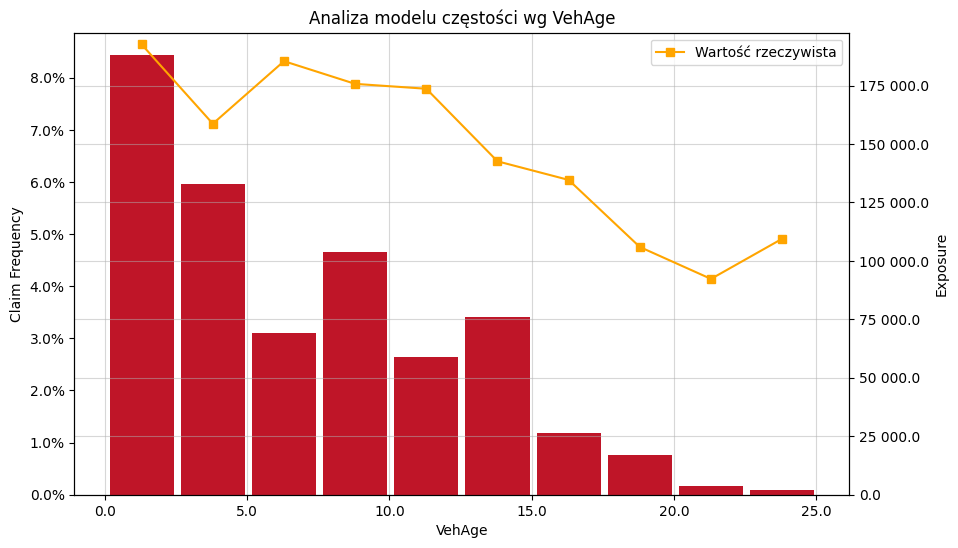

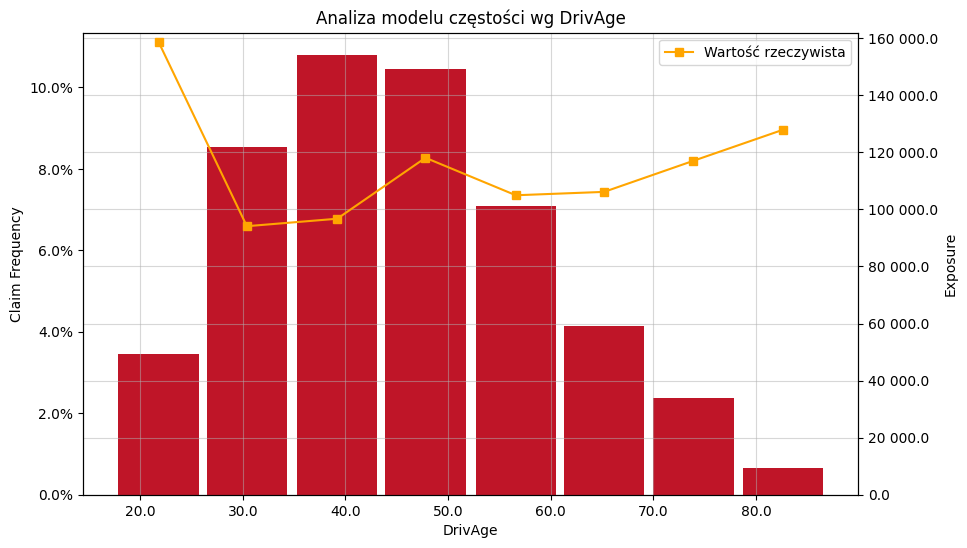

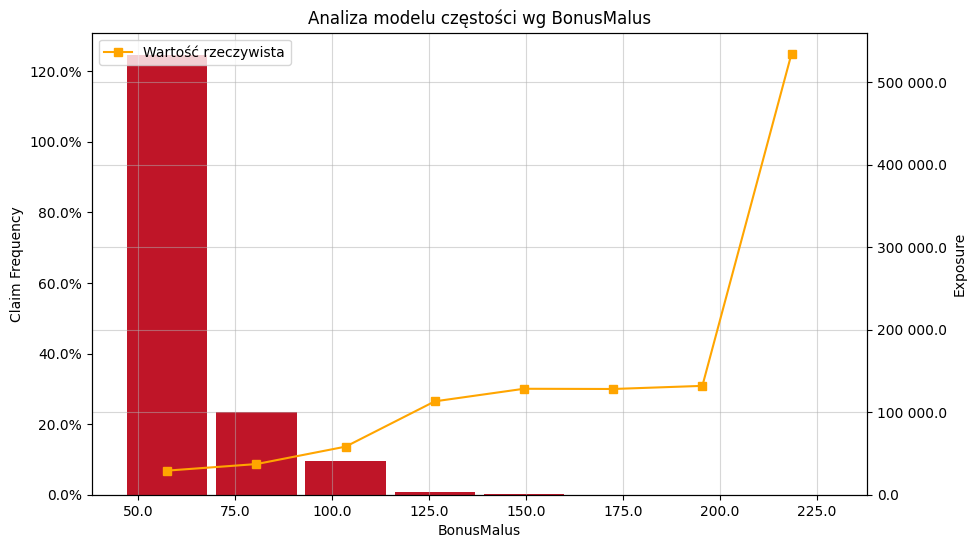

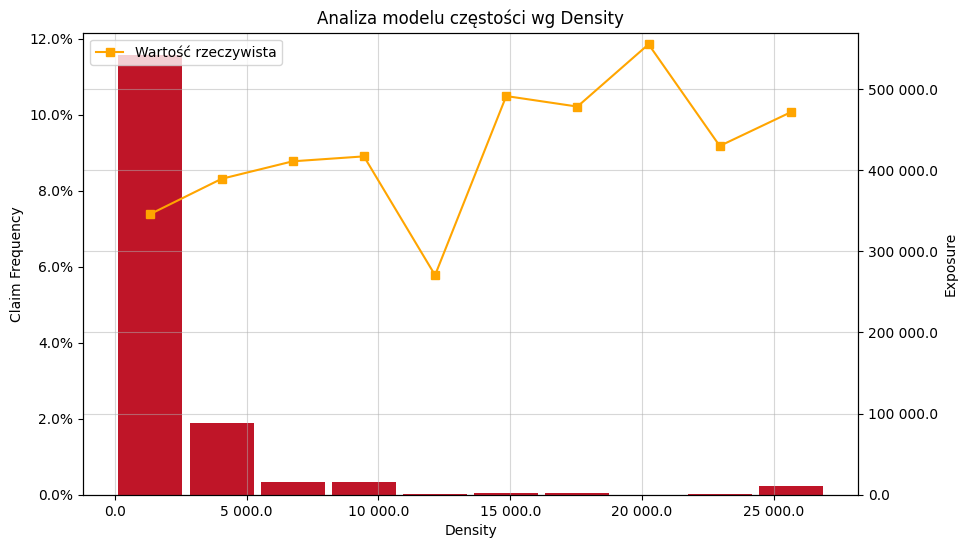

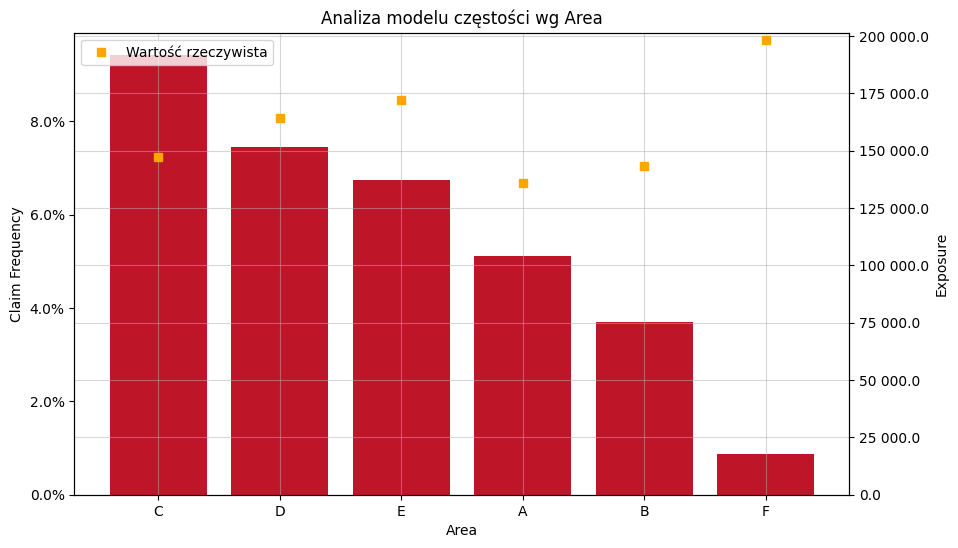

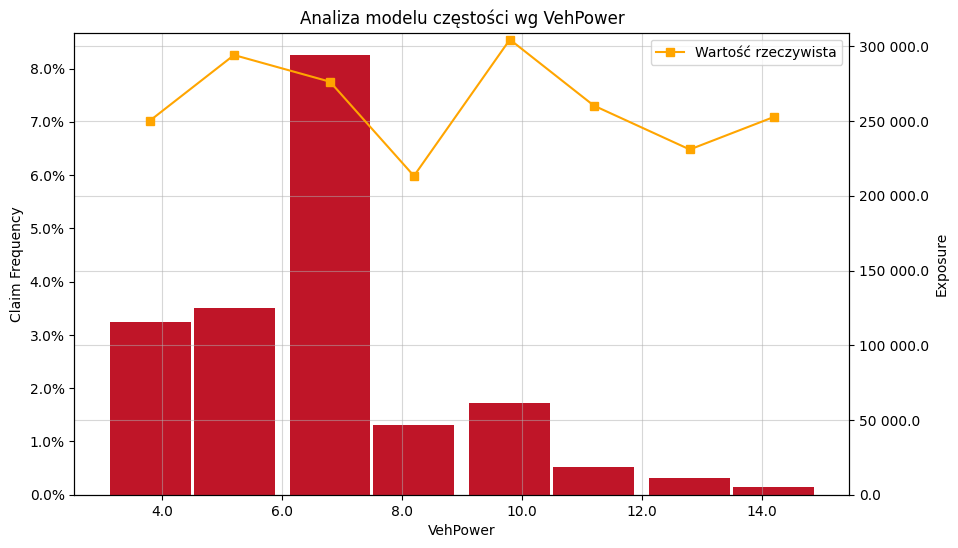

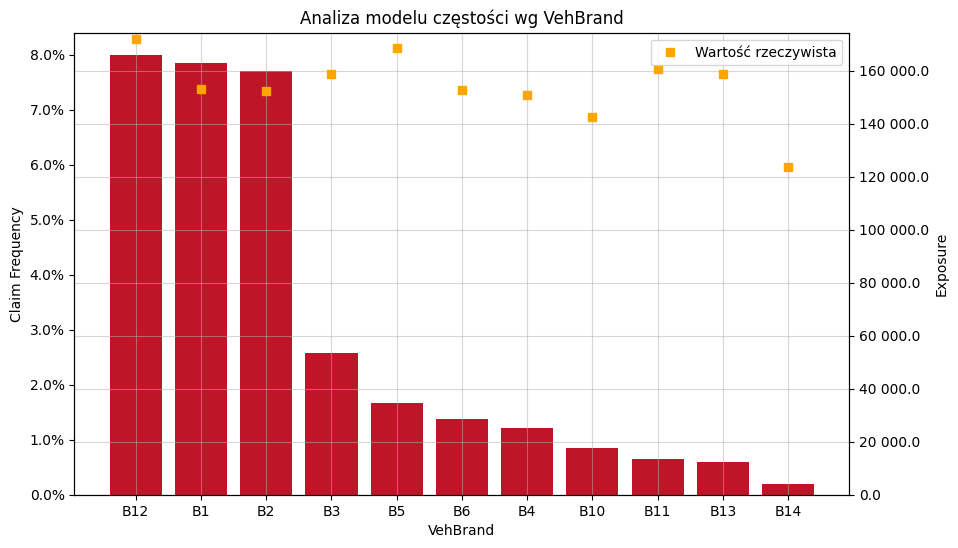

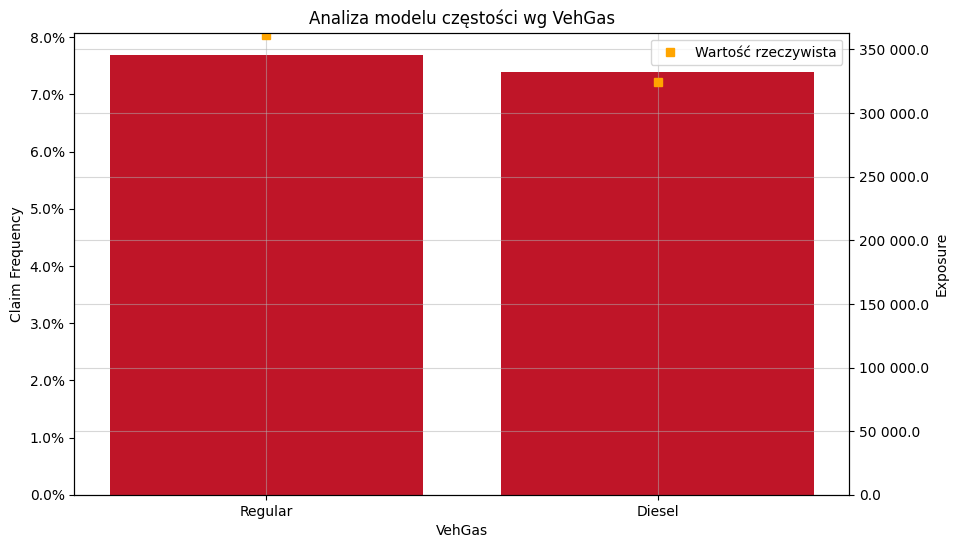

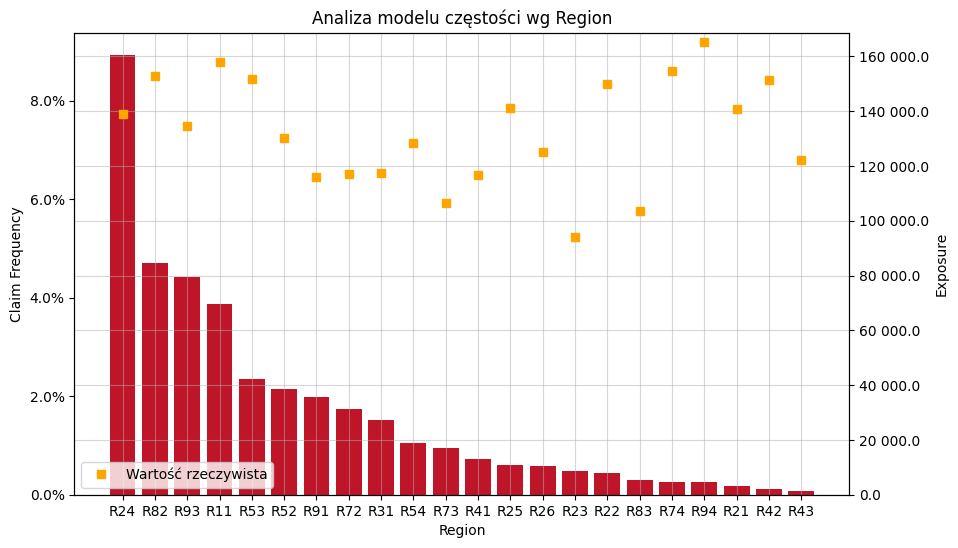

In [122]:
for col in df_freq.columns:
    if col not in ['ClaimFrequency', 'ClaimNb', 'Exposure']:
        wykres_analizy_modelu(
            data=df_freq,
            x=col,
            y='ClaimFrequency',
            title=f'Analiza modelu częstości wg {col}'
        )

Analiza wykazuje że zmienna wiek pojazdu wyraźnie wpływa na zmniejszenie częstości szkód w poszcególnych kategoriach wiekowych, a więc kierowcy starszych aut rzadziej zgłaszają szkody. 

Zależność częstości szkód i wieku kierowcy wykazuje nieliniową zależność, z relatywnie wysoką wartością dla młodych kierowców (ok. 20 roku życia), gwałtownie spadającą dla 30 latków i stopniowo rosnącą wraz z wiekiem. 

Wysokie wartości Bonus Malus również są powiązane z wysoką częstością szkód, pokazując że historia szkodowa może okazać się kluczową w segmentacji szkodowych klientów. Jednak nie bez znaczenia pozostaje fakt niskiego wolumenu danych dla skrajnie wysokich wartości wskaźnika BonusMalus.

Podobnie gęstość zaludnienia wydaje się być dodatni skorelowana z częstością szkód, przy małym wolumenie obserwacji w obszarach o gęstości powyżej 10 000 mieszkańców na km²

Jeśli chodzi o obszar częstością szkód na tle pozostałych wyróżnia się obszar F

Niską częstością szkód na tle pozostałych marek samochodów może pochwlić się marka B14, podobnie diesel okazuje się mieć nieco niższą częstość od benzyny

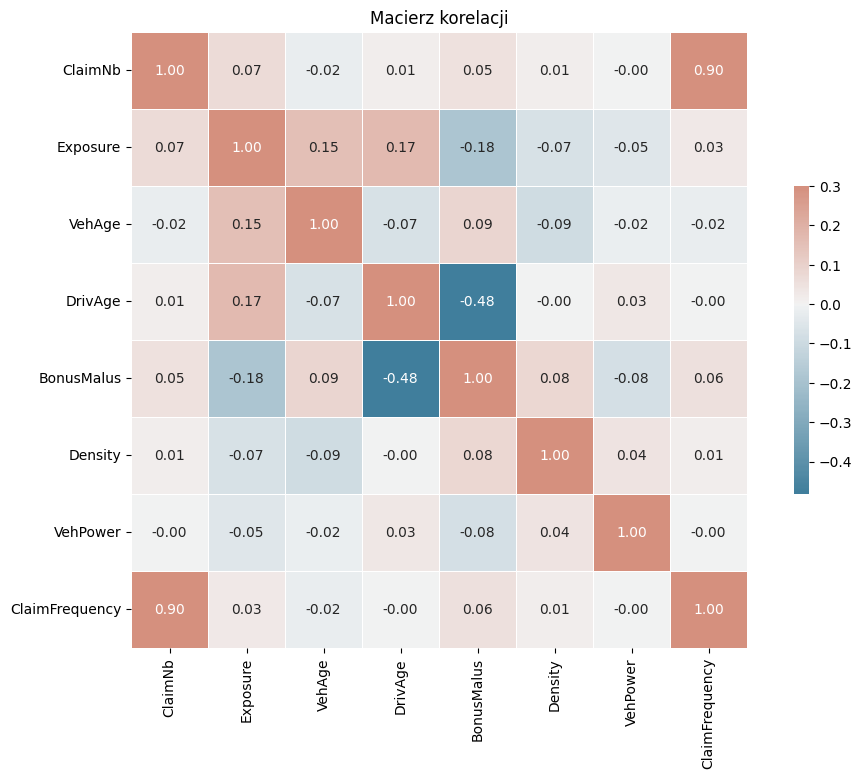

In [124]:
wyswietl_macierz_korelacji(df_freq)

Częstotliwość roszczeń obliczona jako liczba roszczeń podzielona przez okres ekspozycji wykazuje oczywiście wysoką korelację liniową z liczbą roszczeń, nieco nieoczekiwane jest to, że korelacja z okresem ekspozycji jest bliska zeru. Inne cechy wykazują słabą korelację z częstotliwością roszczeń, co wskazuje, że żadna pojedyncza zmienna nie ma na nią silnego liniowego wpływu. BonusMalus wykazuje umiarkowaną ujemną korelację z DrivAge (-0,48), co sugeruje, że młodsi kierowcy mają zazwyczaj wyższe wskaźniki ryzyka, częściowo przez krótką historię prowadzenia pojazdów. Ekspozycja wykazuje łagodną dodatnią korelację z DrivAge i VehAge, ale ogólnie rzecz biorąc, zależności te są słabe.

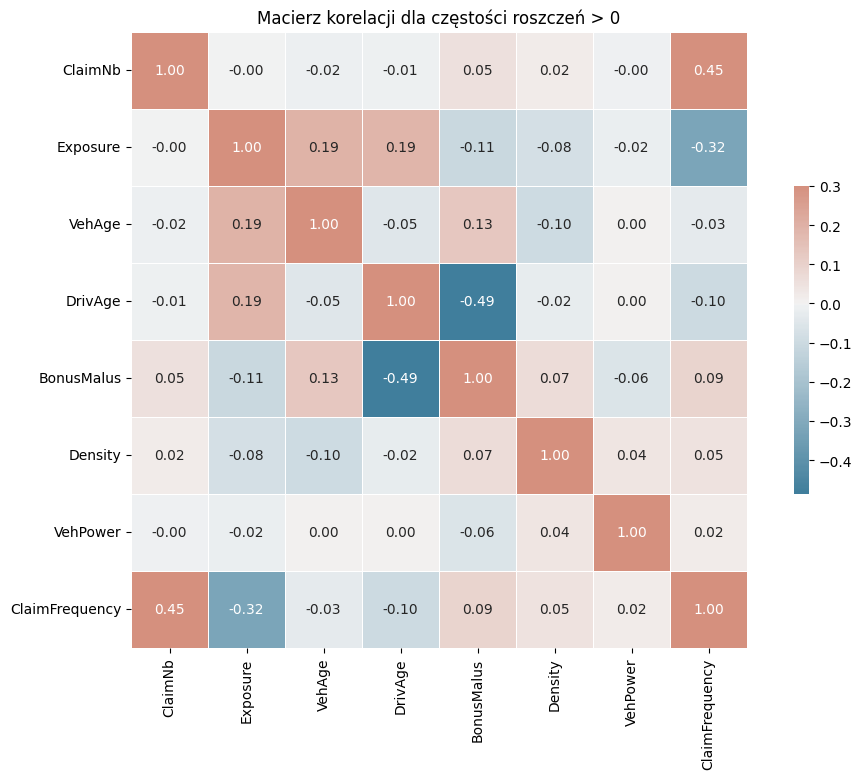

In [125]:
# macierz korelacji dla częstości roszczeń większej niż 0
df_freq_positive = df_freq[df_freq["ClaimFrequency"] > 0]
wyswietl_macierz_korelacji(df_freq_positive, tytul='Macierz korelacji dla częstości roszczeń > 0')

Ograniczenie danych wyłącznie do tych, których częstotliwość roszczeń jest wyższa od 0, wpływa nieco na wygląd macierzy korelacji. Struktura korelacji pozostaje w dużej mierze słaba, co potwierdza, że żadna pojedyncza zmienna nie ma silnego liniowego wpływu na częstotliwość roszczeń. Korelacja między częstotliwością roszczeń a ekspozycją jest umiarkowanie ujemna, podczas gdy wcześniej była bliska zeru. Ujemna korelacja między DrivAge a BonusMalus utrzymuje się. Nieco wyższa korelacja występuje między częstotliwością szkód a innymi cechami, ale nadal jest ona słaba.

In [126]:
# 10 obserwacji z najwyższą częstością roszczeń
top_10 = df_freq.nlargest(n=10, columns=["ClaimFrequency"])
top_10

,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density,Area,VehPower,VehBrand,VehGas,Region,ClaimFrequency
304484,5.0,0.33,12.0,52.0,50.0,824.0,D,4,B1,Regular,R91,15.151515
321248,5.0,0.33,12.0,52.0,50.0,824.0,D,4,B1,Regular,R91,15.151515
364437,4.0,0.27,9.0,23.0,90.0,6924.0,E,5,B3,Diesel,R11,14.814815
320764,5.0,0.41,12.0,52.0,50.0,824.0,D,4,B1,Regular,R91,12.195122
342124,3.0,0.27,7.0,40.0,51.0,403.0,C,5,B2,Diesel,R91,11.111111
522556,3.0,0.30,1.0,71.0,50.0,42.0,A,4,B12,Regular,R52,10.000000
214606,3.0,0.32,10.0,24.0,90.0,1955.0,D,4,B1,Regular,R94,9.375000
203399,3.0,0.36,2.0,57.0,50.0,1217.0,D,4,B4,Regular,R82,8.333333
424360,3.0,0.36,12.0,56.0,101.0,9307.0,E,6,B1,Diesel,R82,8.333333
461814,3.0,0.36,7.0,31.0,68.0,1974.0,D,4,B2,Diesel,R54,8.333333


In [127]:
# 10 obserwacji z najniższą częstością roszczeń
bottom_10 = df_freq.nsmallest(n=10, columns=["ClaimFrequency"])
bottom_10

,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density,Area,VehPower,VehBrand,VehGas,Region,ClaimFrequency
9387,0.0,0.005464,15.0,50.0,50.0,29.0,A,6,B2,Diesel,R24,0.0
9388,0.0,0.670000,15.0,50.0,50.0,29.0,A,6,B2,Diesel,R24,0.0
9389,0.0,0.890000,8.0,30.0,68.0,48.0,A,6,B1,Diesel,R53,0.0
9390,0.0,0.100000,8.0,30.0,57.0,48.0,A,6,B1,Diesel,R53,0.0
9391,0.0,0.200000,4.0,44.0,50.0,56.0,B,7,B14,Diesel,R24,0.0
9392,0.0,0.170000,10.0,49.0,95.0,26.0,A,6,B3,Diesel,R24,0.0
9393,0.0,1.000000,4.0,33.0,50.0,16.0,A,6,B1,Diesel,R24,0.0
9394,0.0,1.000000,8.0,31.0,50.0,17.0,A,7,B5,Diesel,R24,0.0
9395,0.0,1.000000,12.0,46.0,50.0,126.0,C,7,B5,Diesel,R24,0.0
9396,0.0,1.000000,11.0,55.0,50.0,67.0,B,6,B1,Diesel,R24,0.0


### Inżynieria cech

W oparciu o rzeczywistą wiedzę i eksploracyjną analizę danych możemy przeprowadzić inżynierię cech w celu dodatkowej analizy:
- stworzenie cechy, która odzwierciedla związek między mocą pojazdu a wiekiem kierowcy, ponieważ młodsi kierowcy (którzy są ogólnie uważani za bardziej lekkomyślnych) prowadzący pojazdy o dużej mocy mogą być bardziej narażeni na wypadki. 
- zastosowanie transformacji logarytmicznej do cech numerycznych może być korzystne. Macierz korelacji wskazuje na brak liniowej zależności między zmiennymi, transformacja logarytmiczna może pomóc w normalizacji rozkładów i ukazać zależności liniowe między transformacjami poszczególnych zmiennych.

c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Analiza danych z Pythonem\PrzewidywanieCzestosciSzkod\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


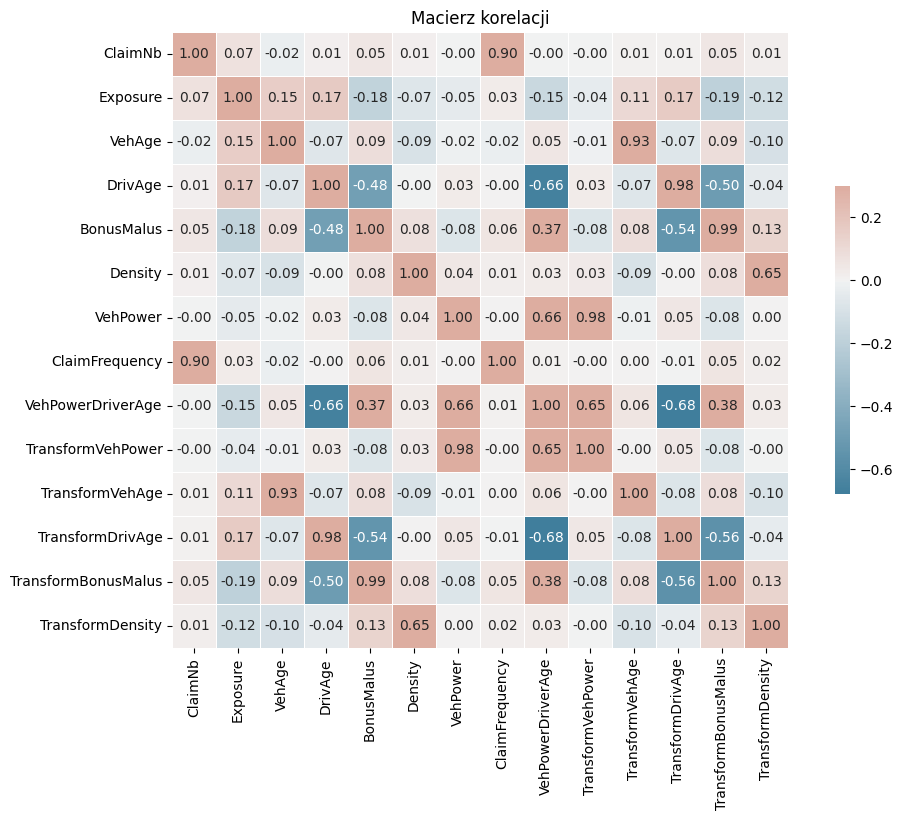

In [128]:
df_fe = df_freq

# stworzenie cechy: moc pojazdu do wieku kierowcy
df_fe["VehPowerDriverAge"] = df_fe["VehPower"]/df_fe["DrivAge"]

# transformacje logarytmiczne wybranych cech
variables=["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]
for i in variables:
    df_fe[f"Transform{i}"] = np.log(df_fe[i])

# macierz korelacji dla częstości roszczeń większej niż 0 po inżynierii cech
wyswietl_macierz_korelacji(df_fe)

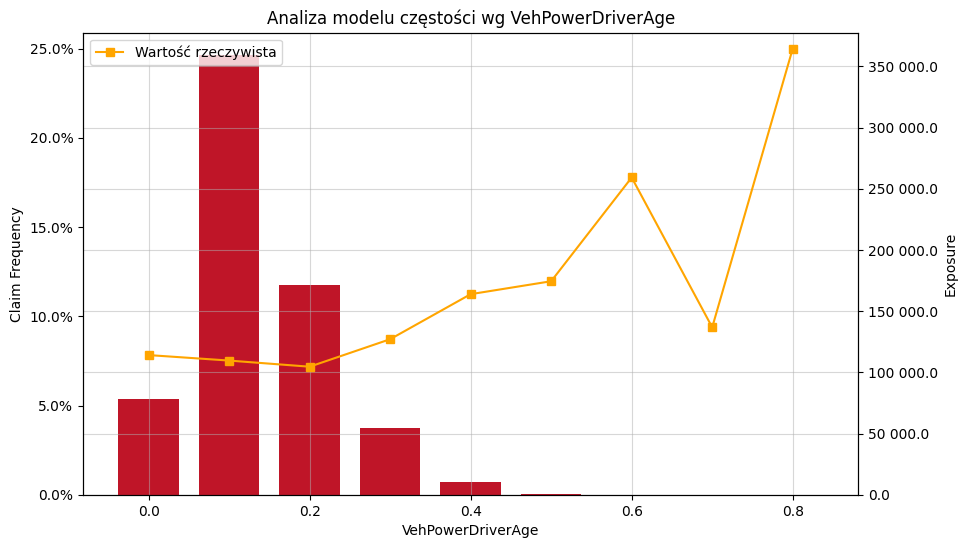

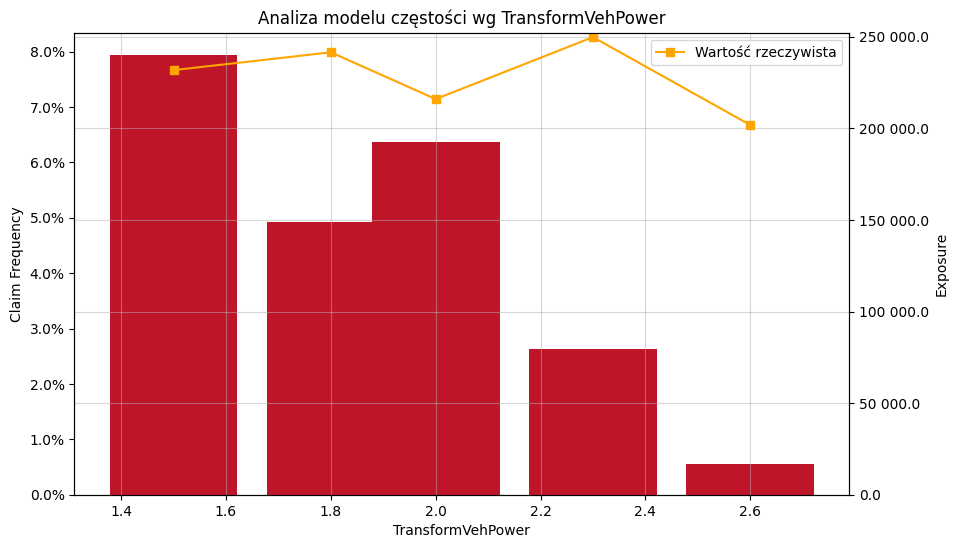

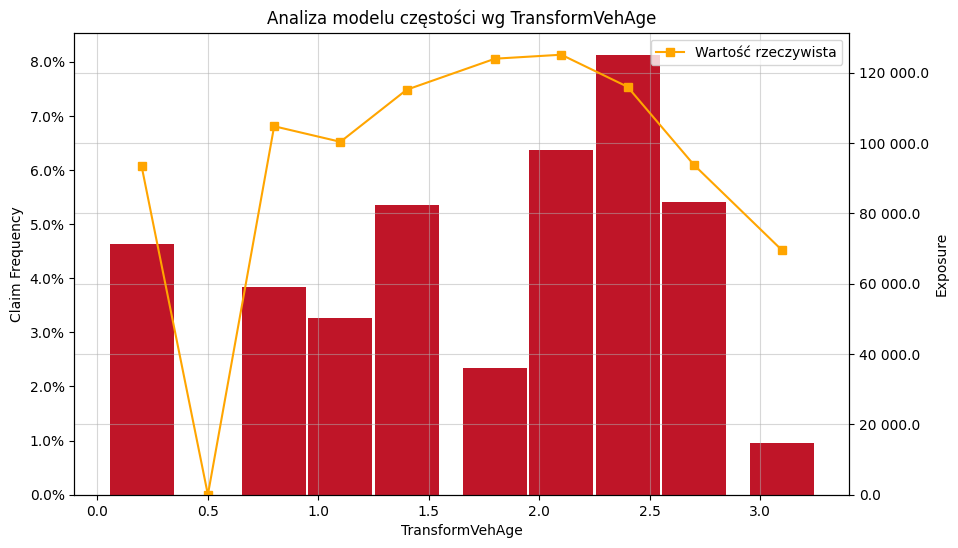

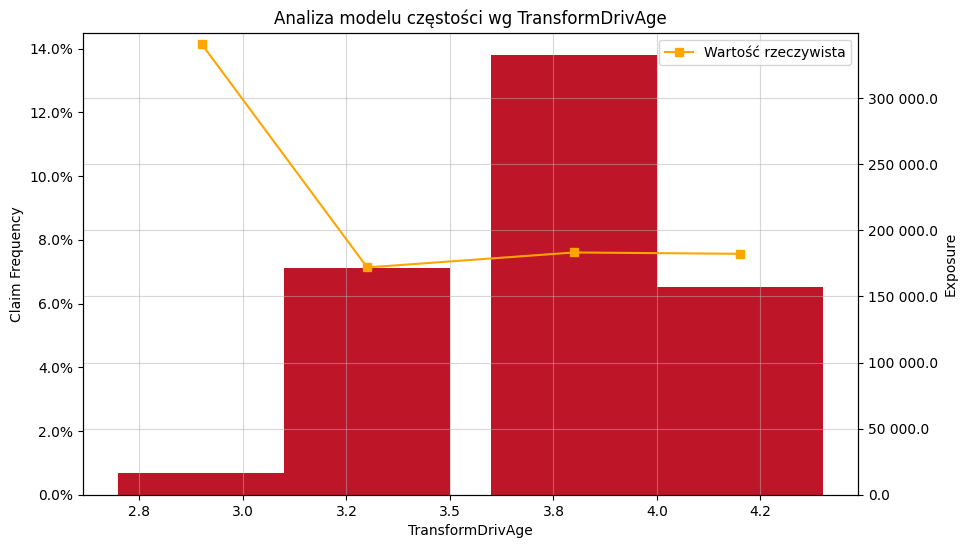

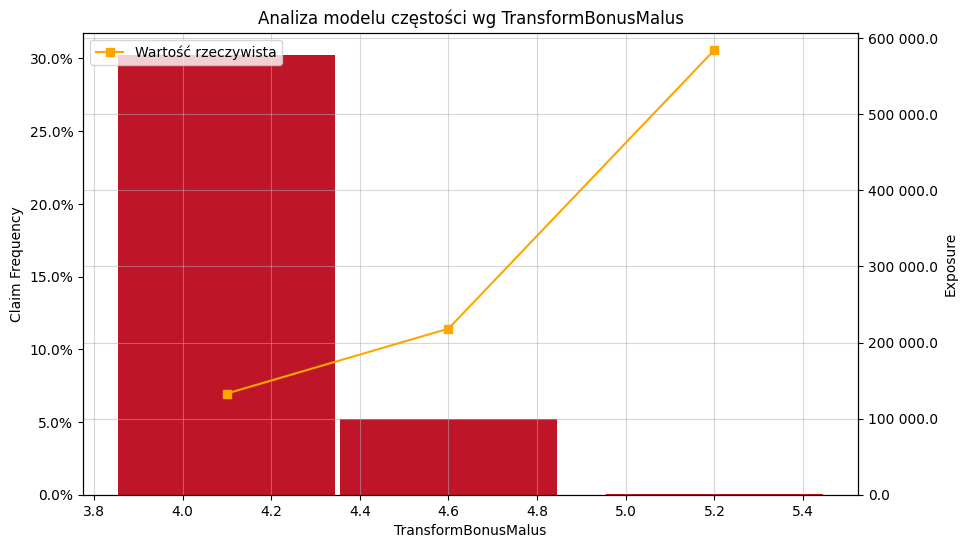

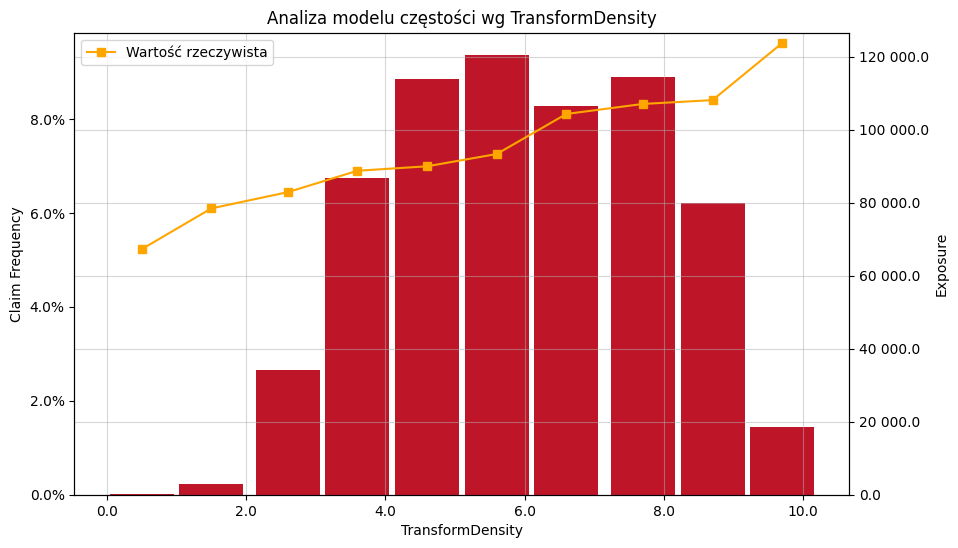

In [129]:
for col in ["VehPowerDriverAge", "TransformVehPower", "TransformVehAge", "TransformDrivAge", "TransformBonusMalus", "TransformDensity"]:
    wykres_analizy_modelu(
        data=df_fe,
        x=col,
        y='ClaimFrequency',
        title=f'Analiza modelu częstości wg {col}'
    )

Nowo utworzone cechy, moc pojazdu podzielona przez wiek kierowcy, nadal wykazuje słabą korelację liniową z częstotliwością zgłoszeń szkód. Jednak spośród wszystkich dostępnych cech pozostaje ona jednym z najsilniejszych czynników prognostycznych, co sprawia, że warto ją zachować jako zmienną. Z drugiej strony, zastosowanie transformacji do cech numerycznych nie poprawiło znacząco korelacji ani rozkładu częstotliwości szkód, z wyjątkiem przypadków Bonus/Malus i Gęstość. Ponieważ przekształcone wersje tych dwóch zmiennych wykazują lepszy związek z częstotliwością szkód, zachowam je i usunę wersje oryginalne.

In [130]:
# usuwanie niepotrzebnych cech
df_fe.drop(["BonusMalus", "Density", "TransformVehPower", "TransformDrivAge", "TransformVehAge", "ClaimNb", "Exposure"], axis=1, inplace=True)

# zapisywanie danych po inżynierii cech
df_fe.to_csv("./feature_selected_data.csv", index=False)

## Wnioskowanie statystyczne

In [132]:
df = pd.read_csv("feature_selected_data.csv")
df.head()

,VehAge,DrivAge,Area,VehPower,VehBrand,VehGas,Region,ClaimFrequency,VehPowerDriverAge,TransformBonusMalus,TransformDensity
0,0.0,55.0,D,5,B12,Regular,R82,1.000000,0.090909,3.912023,7.104144
1,0.0,55.0,D,5,B12,Regular,R82,1.298701,0.090909,3.912023,7.104144
2,2.0,52.0,B,6,B12,Diesel,R22,1.333333,0.115385,3.912023,3.988984
3,0.0,46.0,B,7,B12,Diesel,R72,1.000000,0.152174,3.912023,4.330733
4,0.0,46.0,B,7,B12,Diesel,R72,1.190476,0.152174,3.912023,4.330733


Estymowana lambda (średnia): 0.0763279516961605
Wariancja danych: 0.14673895902859746


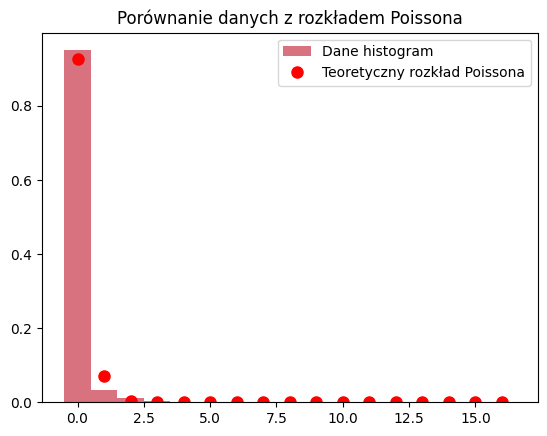

In [142]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

dane = df['ClaimFrequency']

# Estymacja parametru lambda
print(f"Estymowana lambda (średnia): {np.mean(dane)}")
print(f"Wariancja danych: {np.var(dane)}")

# Wizualizacja
plt.hist(dane, bins=np.arange(min(dane)-0.5, max(dane)+1.5, 1), density=True, alpha=0.6, color='#BF1528', label='Dane histogram')
x = np.arange(min(dane), max(dane) + 1)
plt.plot(x, poisson.pmf(x, np.mean(dane)), 'ro', ms=8, label='Teoretyczny rozkład Poissona')
plt.legend()
plt.title('Porównanie danych z rozkładem Poissona')
plt.show()

Rozkład częstotliwości szkód jest silnie prawo-stronnie asymetryczny, a wariancja jest prawie dwukrotnie większa od średniej. Ta nadmierna dyspersja sugeruje, że rozkład Poissona może nie oddawać w pełni rozkładu zmiennych.

In [139]:
from scipy.stats import chisquare, poisson

observed_counts = np.bincount(dane)
expected_probs = poisson.pmf(np.arange(len(observed_counts)), np.mean(dane))
expected_counts = expected_probs * len(dane)

# Test chi-kwadrat
chi2, p_value = chisquare(f_obs=observed_counts, f_exp=expected_counts)
print("Test Chi-kwadrat:")
print(f"Statystyka = {chi2:.4f}")
print(f"p-value = {p_value:.4f}")

Test Chi-kwadrat:
Statystyka = 479477703451202625208320.0000
p-value = 0.0000


C:\Users\norbe\AppData\Local\Temp\ipykernel_20128\1301129722.py:3: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  observed_counts = np.bincount(dane)


Na podstawie testu chi-kwadrat odrzucam hipotezę zerową mówiąca o tym że dane pochodzą z rozkładu Poissona

### Wykorzystanie modelu "Zero-inflated" do sprawdzenia istotności statystycznej zmiennych

Model "Zero-Inflated" (z nadmiarem zer) zakłada, że w danych istnieją dwa oddzielne procesy, które generują wynik.
Etap 1 (Proces Binarny/Logit): System "decyduje", czy dany klient w ogóle może mieć szkodę.

Jeśli "Nie": Wynik to gwarantowane zero (tzw. Structural Zero).

Jeśli "Tak": Przechodzimy do etapu 2.

Etap 2 (Proces Poissona): Dla klientów, którzy "mogą" mieć szkodę, losujemy ich liczbę z rozkładu Poissona.

Mogą wylosować 1, 2, 3 szkody ale mogą też wylosować zero (tzw. Sampling Zero – losowe zero).

In [146]:
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedPoisson

exog = np.ones(len(df)).reshape(-1, 1)

poisson_mod = sm.GLM(df['ClaimFrequency'], exog, 
                     family=sm.families.Poisson()).fit()

zip_mod = ZeroInflatedPoisson(df['ClaimFrequency'], exog, 
                              exog_infl=exog).fit()

# Porównanie modeli (Kryterium Informacyjne AIC)
print(f"AIC Poisson: {poisson_mod.aic:.2f}")
print(f"AIC Zero-Inflated: {zip_mod.aic:.2f}")

Optimization terminated successfully.
         Current function value: 0.248404
         Iterations: 11
         Function evaluations: 19
         Gradient evaluations: 19
AIC Poisson: 399835.84
AIC Zero-Inflated: 336846.77


Według kryterium informacyjnego Akaike model Zero-Inflated Poisson jest lepszym modelem

In [153]:
from sklearn.compose import ColumnTransformer

X = df.drop(columns=['ClaimFrequency'], axis=1)
y = df['ClaimFrequency'].squeeze()

num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop="first"), cat_features) # Usuwanie pierwszej zmiennej kategorycznej, w celu uniknięcia współliniowości (Area_A, Region_R11, VehBrand_B1, VehGas_Diesel)
])

X_transformed = preprocessor.fit_transform(X).toarray()

y = y.reset_index(drop=True)

In [160]:
if isinstance(X_transformed, np.ndarray):
    col_names = [f"x{i}" for i in range(X_transformed.shape[1])]
    X_transformed = pd.DataFrame(X_transformed, columns=col_names)

if isinstance(y, pd.DataFrame):
    y = y.squeeze()

X = X_transformed.copy()
X_infl = X_transformed.copy()

zip_model = ZeroInflatedPoisson(y, sm.add_constant(X), exog_infl=sm.add_constant(X_infl)).fit(maxiter=1, disp=0)
klasa_modelu = zip_model.model.__class__

print(f"Startowe AIC: {zip_model.aic:.2f}")

while True:
    p_wartosci = zip_model.pvalues.drop('const', errors='ignore')
    
    if p_wartosci.empty:
        print("Brak zmiennych do usunięcia lub błąd modelu.")
        break

    najgorsza_cecha = p_wartosci.idxmax()
    max_p = p_wartosci.max()
    
    print(f"Najgorsza: {najgorsza_cecha}, p-value: {max_p:.4f}")
    
    if max_p > 0.05:
        if najgorsza_cecha.startswith("inflate_"):
            oryginalna_cecha = najgorsza_cecha.replace("inflate_", "", 1)
            if oryginalna_cecha in X_infl.columns:
                print(f"--> Usuwam {oryginalna_cecha} z części Inflated")
                X_infl = X_infl.drop(columns=[oryginalna_cecha])
            else:
                print(f"Nie znaleziono kolumny {oryginalna_cecha} w X_infl. Przerywam.")
                break
        else:
            if najgorsza_cecha in X.columns:
                print(f"--> Usuwam {najgorsza_cecha} z części Poisson")
                X = X.drop(columns=[najgorsza_cecha])
            else:
                print(f"Nie znaleziono kolumny {najgorsza_cecha} w X. Przerywam.")
                break
        
        try:
            zip_model = klasa_modelu(y, sm.add_constant(X), exog_infl=sm.add_constant(X_infl), inflation='logit').fit(maxiter=1, disp=0)
        except Exception as e:
            print(f"Błąd zbieżności modelu: {e}")
            break
    else:
        print("Koniec selekcji. Wszystkie zmienne istotne.")
        break

print(zip_model.summary())

c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Analiza danych z Pythonem\PrzewidywanieCzestosciSzkod\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Startowe AIC: 378890.90
Najgorsza: x31, p-value: 0.9917
--> Usuwam x31 z części Poisson


c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Analiza danych z Pythonem\PrzewidywanieCzestosciSzkod\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Najgorsza: x30, p-value: 0.9853
--> Usuwam x30 z części Poisson


c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Analiza danych z Pythonem\PrzewidywanieCzestosciSzkod\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Najgorsza: x22, p-value: 0.9816
--> Usuwam x22 z części Poisson


c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Analiza danych z Pythonem\PrzewidywanieCzestosciSzkod\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Najgorsza: x15, p-value: 0.9807
--> Usuwam x15 z części Poisson


c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Analiza danych z Pythonem\PrzewidywanieCzestosciSzkod\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Najgorsza: x39, p-value: 0.9768
--> Usuwam x39 z części Poisson


c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Analiza danych z Pythonem\PrzewidywanieCzestosciSzkod\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Najgorsza: x37, p-value: 0.9700
--> Usuwam x37 z części Poisson


KeyboardInterrupt: 

In [ ]:
coefs = zip_model.params.drop('const')
pvalues = zip_model.pvalues.drop('const')

results_df = pd.DataFrame({'Coefficient': coefs, 'P-Value': pvalues})
results_df = results_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y=results_df.index, data=results_df, 
            hue='Significance', dodge=False, palette={'Significant': '#2ecc71', 'Not Sig': '#95a5a6'})
plt.title('What Drives Life Satisfaction? (Standardized Coefficients)')
plt.xlabel('Impact on Life Satisfaction (Std Dev)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Ze względu na złożoność obliczeniową finalne wyniki testów statystycznych przekroczyły mozliwości mojego komputera osobistego, więc finalnie nie mogę wnioskować na ich podstawie.

## Podsumowanie i wnioski końcowe

W ramach projektu przeprowadzono analizę czynników wpływających na częstość występowania szkód komunikacyjnych (ClaimNb) na podstawie zbioru danych freMTPL2freq (French Motor Third-Party Liability Claims). Zbiór ten charakteryzuje się typową dla ubezpieczeń nadreprezentacją zer (zero-inflation) – zdecydowana większość polis nie odnotowuje żadnej szkody w okresie obserwacji.

Na podstawie eksploracyjnej analizy danych (EDA) zidentyfikowano następujące zależności, które mają kluczowe znaczenie dla taryfikacji ubezpieczeniowej:

1. Historia ubezpieczeniowa (Bonus-Malus): Jest to najsilniejszy predyktor ryzyka. Istnieje dodatnia korelacja między wysokim współczynnikiem BonusMalus a częstością szkód. Klienci z "czystą kartą" generują istotnie mniej roszczeń.

2. Wiek kierowcy (DrivAge): Najwyższe ryzyko obserwuje się w grupie najmłodszych kierowców (brak doświadczenia) oraz, w mniejszym stopniu, u kierowców najstarszych. Grupa wiekowa 30-60 lat charakteryzuje się największą stabilnością.

3. Moc pojazdu (VehPower): Pojazdy o wyższej mocy silnika wykazują tendencję do wyższej częstości szkód, co uzasadnia stosowanie zwyżek składek dla aut sportowych i o dużej pojemności.

4. Obszar geograficzny (Density / Area): Użytkowanie pojazdu w strefach o wysokiej gęstości zaludnienia zwiększa prawdopodobieństwo wystąpienia szkody, w przeciwieństwie do terenów wiejskich.

W procesie modelowania podjęto próbę porównania dwóch podejść:

Standardowy model Poissona (GLM): Zakładający, że wariancja jest równa wartości oczekiwanej.

Model Zero-Inflated Poisson (ZIP): Zakładający istnienie dwóch procesów: binarnego (czy szkoda w ogóle jest możliwa) oraz licznikowego (ile szkód wystąpi).

Podczas próby optymalizacji modelu ZIP metodą wstecznej selekcji krokowej (backward selection) napotkano istotne bariery obliczeniowe. Algorytm iteracyjny dla zbioru danych liczącego blisko 680 tys. rekordów, przy złożonej strukturze modelu ZIP (jednoczesne estymowanie procesu Logit i Poisson), wymaga zasobów sprzętowych przekraczających możliwości standardowej stacji roboczej.

### Wnioski techniczne:

Dla tak dużych zbiorów danych, pełna selekcja krokowa "brute-force" jest nieefektywna.

W środowisku produkcyjnym zalecanym podejściem jest preselekcja zmiennych na podstawie macierzy korelacji lub lasów losowych (Random Forest Feature Importance) przed uruchomieniem modelu parametrycznego ZIP/GLM.

Alternatywą dla modelu ZIP może być Ujemny Rozkład Dwumianowy (Negative Binomial), który jest często obliczeniowo lżejszy i równie dobrze radzi sobie z nadmierną dyspersją danych ubezpieczeniowych.